In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

import segyio

In [2]:
filename = '/nvme/h/jzhao/data_p131/models/EAGE/2D_Land_vibro_data_2ms/Line_001.sgy'

In [3]:
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    print(n_traces, sample_rate, n_samples, data.shape)

clip_percentile = 99
vm = np.percentile(data, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'

71284 2.0 1501 (71284, 1501)


'The 99th percentile is 0; the max amplitude is 5110'

In [4]:
dt = (twt[1]-twt[0]) * 1e-3
print(dt)

0.002


In [5]:
ntraces, nt = data.shape
nrec = 284
nsrc = int(ntraces / nrec)
print(ntraces, nt, nsrc, nrec)
data = np.reshape(data, (nsrc, nrec, nt))
print(data.shape)

71284 1501 251 284
(251, 284, 1501)


In [6]:
# Mute a couple of corrupted channels
data[:, :2, :] = 0.

In [7]:
data.shape

(251, 284, 1501)

In [8]:
from utils.loaders import bandpass

for idx in range(data.shape[0]):
    data[idx,:,:] = bandpass(data[idx,:,:], fhi=20, dt=dt, order=8, btype='low', verbose=0)

In [9]:
_data = data[:,:,::8]
_data.shape

(251, 284, 188)

In [10]:
def plot_shot(shot, pclip=1.0, title='', colorbar=True, dt=None, dx=None, 
              figsize=None, axis=True, ax=None, cax_label='', dpi=None, **kwargs):
    """ Plot a seismic shot gather given as 2d array [offset, time] """
    if isinstance(shot, list):
        shot = np.concatenate(shot, 0)
        
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize if figsize else None);
        if dpi:
            fig.set_dpi(dpi)
        
    vlim = pclip * np.max(np.abs(shot)); 

    if dt or dx:
        nx, nt = shot.shape                                                
        kwargs['extent'] = [0, nx*dx/1000 if dx else nx, 0, nt*dt if dt else nt]
        if dx: 
            ax.set_xlabel('km');
        else: 
            ax.set_visible(False)
        if dt: 
            ax.set_ylabel('sec');
        else: 
            ax.set_visible(False)
            
    if not 'cmap' in kwargs.keys():
        kwargs['cmap'] = 'Greys'
    kwargs['vmin'] = -vlim if not 'vmin' in kwargs.keys() else kwargs['vmin']
    kwargs['vmax'] = vlim if not 'vmax' in kwargs.keys() else kwargs['vmax']
    
    im = ax.imshow(np.flip(shot, -1).T, **kwargs)
    
    if colorbar:
        divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05);
        plt.colorbar(im, cax=cax, label=cax_label);
        
    ax.set_title(title); 
    ax.axis('auto' if axis else 'off'); ax.invert_yaxis();

In [11]:
def plot_spectrum(shot, dt, title='', fmax=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ps = np.sum(np.abs(np.fft.fft(shot)) ** 2, axis=-2); 
    freqs = np.fft.fftfreq(len(ps), dt); 
    idx = np.argsort(freqs)
    causal = int(len(ps) // 2); 
    freqs, ps = freqs[idx], ps[idx]; 
    freqs = freqs[-causal:]; 
    ps = ps[-causal:]; 
    freqs = freqs[freqs < (fmax if fmax else np.max(freqs))]; 
    n = len(freqs); 
    ax.plot(freqs[:n], ps[:n], label=title); 
    ax.set_xlabel('Frequency (Hz)'); 
    ax.set_ylabel('Gain'); ax.grid(True);


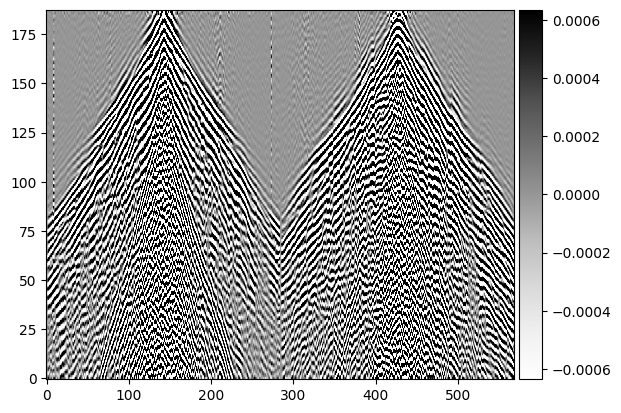

In [12]:
plot_shot([_data[1], _data[200]], pclip=0.001)

In [13]:
# vfmax = 20
# vfmin = 10

# fig, ax = plt.subplots(1, 1)
# plot_spectrum(_data[1], dt, ax=ax, fmax=vfmax)
# plot_spectrum(_data[200], dt, ax=ax, fmax=vfmax)

In [14]:
from skimage.transform import resize

In [15]:
_data = resize(_data.T, (224, 224))

In [16]:
_data.shape

(224, 224, 251)

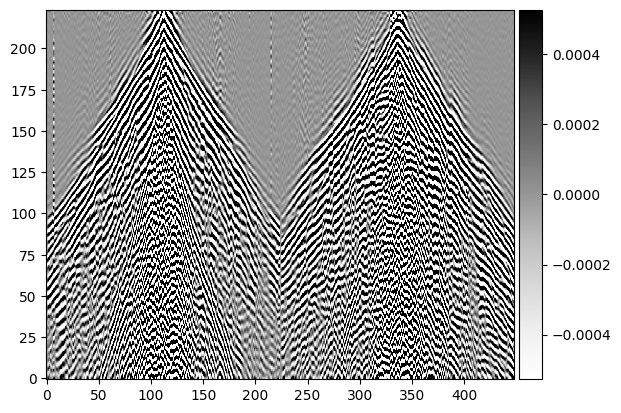

In [17]:
plot_shot([_data.T[1], _data.T[200]], pclip=0.001)

In [18]:
import torch

def prep(dat):
    """normalize data by its absmax"""
    si = np.max(np.abs(dat)[:])
    dat /= si
    return dat


class CubeLoader(torch.utils.data.Dataset):
    """Create loader from [nsamp, noffsets, ntimes]"""
    def __init__(self, dat):
        self.dat = dat
    
    def __len__(self):
        return self.dat.shape[0]
    
    def __getitem__(self, item):
        dat = self.dat[item, ...]
        dat = prep(dat)
        # dat = np.expand_dims(dat, axis=0)
        dat = np.stack((dat, dat, dat), axis=0)
        return (dat.astype(np.float32), item)

In [19]:
dataset = CubeLoader(_data.T)

In [20]:
# batch_size = 8 
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# for batch_data, batch_indices in data_loader:
#     print(batch_data.shape, batch_indices)

In [21]:
from torch.utils.data import DataLoader, Subset

dataset_size = len(dataset)
train_size = int(0.95 * dataset_size)
validation_size = dataset_size - train_size

indices = torch.randperm(dataset_size).tolist()

train_dataset = Subset(dataset, indices[:train_size])
validation_dataset = Subset(dataset, indices[train_size:])

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

for batch_data, batch_indices in train_loader:
    print("Training batch shape:", batch_data.shape, "Indices:", batch_indices)

for batch_data, batch_indices in validation_loader:
    print("Validation batch shape:", batch_data.shape, "Indices:", batch_indices)

Training batch shape: torch.Size([8, 3, 224, 224]) Indices: tensor([ 86,  55,  94,   2, 103,  97, 127, 244])
Training batch shape: torch.Size([8, 3, 224, 224]) Indices: tensor([120,  64, 149, 154, 119, 128, 130,  96])
Training batch shape: torch.Size([8, 3, 224, 224]) Indices: tensor([101, 102, 132, 194,  20, 228,   7,  67])
Training batch shape: torch.Size([8, 3, 224, 224]) Indices: tensor([ 91,  15, 108, 200, 151,  11, 199, 198])
Training batch shape: torch.Size([8, 3, 224, 224]) Indices: tensor([ 36, 170, 207, 217, 210, 141,  92,  42])
Training batch shape: torch.Size([8, 3, 224, 224]) Indices: tensor([214, 208,  28,  43, 182, 233, 152,  69])
Training batch shape: torch.Size([8, 3, 224, 224]) Indices: tensor([243,  45,  60, 193, 234, 191,  82, 196])
Training batch shape: torch.Size([8, 3, 224, 224]) Indices: tensor([  8,  75,  17,  93, 131, 213, 165,  37])
Training batch shape: torch.Size([8, 3, 224, 224]) Indices: tensor([169, 180, 222, 179, 202, 118, 221,  25])
Training batch shap

In [22]:
import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import timm
import timm.optim.optim_factory as optim_factory

import mae.util.misc as misc
from mae.util.misc import NativeScalerWithGradNormCount as NativeScaler

import mae.models_mae as models_mae

from mae.engine_pretrain import train_one_epoch

In [23]:
import torch.distributed as dist

device = torch.device('cuda')

# fix the seed for reproducibility
seed = misc.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)

cudnn.benchmark = True

# simple augmentation
# transform_train = transforms.Compose([
#             transforms.RandomResizedCrop(args.input_size, scale=(0.2, 1.0), interpolation=3),  # 3 is bicubic
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# dataset_train = datasets.ImageFolder(os.path.join(args.data_path, 'train'), transform=transform_train)
# print(dataset_train)

# if True:  # args.distributed:
#     num_tasks = misc.get_world_size()
#     global_rank = misc.get_rank()
#     sampler_train = torch.utils.data.DistributedSampler(
#     dataset_train, num_replicas=num_tasks, rank=global_rank, shuffle=True
#     )
#     print("Sampler_train = %s" % str(sampler_train))
# else:
#     sampler_train = torch.utils.data.RandomSampler(dataset_train)

# if global_rank == 0 and args.log_dir is not None:
#     os.makedirs(args.log_dir, exist_ok=True)
#     log_writer = SummaryWriter(log_dir=args.log_dir)
# else:
#     log_writer = None

# data_loader_train = torch.utils.data.DataLoader(
#     dataset_train, sampler=sampler_train,
#     batch_size=args.batch_size,
#     num_workers=args.num_workers,
#     pin_memory=args.pin_mem,
#     drop_last=True,
# )
    
# define the model
model = models_mae.__dict__['mae_vit_huge_patch14'](norm_pix_loss=True)

model.to(device)

model_without_ddp = model
print("Model = %s" % str(model_without_ddp))

batch_size = 8
accum_iter = 1

blr = 1.5e-2

weight_decay = 0.05

eff_batch_size = batch_size * accum_iter * misc.get_world_size()
    
lr = blr * eff_batch_size / 256

print("base lr: %.2e" % (lr * 256 / eff_batch_size))
print("actual lr: %.2e" % lr)

print("accumulate grad iterations: %d" % accum_iter)
print("effective batch size: %d" % eff_batch_size)

if dist.is_initialized():
    model = torch.nn.parallel.DistributedDataParallel(model, find_unused_parameters=True)
    model_without_ddp = model.module
    
# following timm: set wd as 0 for bias and norm layers
param_groups = optim_factory.add_weight_decay(model_without_ddp, weight_decay)
optimizer = torch.optim.AdamW(param_groups, lr=lr, betas=(0.9, 0.95))
print(optimizer)
loss_scaler = NativeScaler()

Model = MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (attn): Att

In [24]:
epochs = 50
start_epoch = 0
log_writer = SummaryWriter(log_dir='./log')

In [25]:
warmup_epochs = 5
min_lr = 0
output_dir = './log'

In [26]:
print(f"Start training for {epochs} epochs")
start_time = time.time()
for epoch in range(start_epoch, epochs):
    if dist.is_initialized():
        train_loader.sampler.set_epoch(epoch)
    train_stats = train_one_epoch(
        model, train_loader,
        optimizer, device, epoch, loss_scaler,
        accum_iter, lr, warmup_epochs, min_lr, epochs,
        log_writer=log_writer
    )
    if log_writer is not None and (epoch % 20 == 0 or epoch + 1 == epochs):
        misc.save_model(output_dir=output_dir,
            model=model, model_without_ddp=model_without_ddp, optimizer=optimizer,
            loss_scaler=loss_scaler, epoch=epoch)

    log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                    'epoch': epoch,}

    if log_writer is not None:
        log_writer.flush()
    # with open(os.path.join('./output_dir', "log.txt"), mode="a", encoding="utf-8") as f:
    #     f.write(json.dumps(log_stats) + "\n")

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))

Start training for 50 epochs
log_dir: ./log
Epoch: [0]  [ 0/30]  eta: 1:15:08  lr: 0.000000  loss: 1.5415 (1.5415)  time: 150.2676  data: 0.0747  max mem: 10366
Epoch: [0]  [20/30]  eta: 0:01:13  lr: 0.000000  loss: 1.5009 (1.5036)  time: 0.2121  data: 0.0282  max mem: 13189
Epoch: [0]  [29/30]  eta: 0:00:05  lr: 0.000000  loss: 1.4938 (1.5013)  time: 0.1765  data: 0.0360  max mem: 13189
Epoch: [0] Total time: 0:02:36 (5.2086 s / it)
Averaged stats: lr: 0.000000  loss: 1.4938 (1.5013)
log_dir: ./log
Epoch: [1]  [ 0/30]  eta: 0:00:05  lr: 0.000094  loss: 1.5277 (1.5277)  time: 0.1739  data: 0.0112  max mem: 13189
Epoch: [1]  [20/30]  eta: 0:00:01  lr: 0.000000  loss: 1.2069 (1.2248)  time: 0.1592  data: 0.0230  max mem: 13189
Epoch: [1]  [29/30]  eta: 0:00:00  lr: 0.000000  loss: 1.2083 (1.2174)  time: 0.1742  data: 0.0370  max mem: 13189
Epoch: [1] Total time: 0:00:05 (0.1674 s / it)
Averaged stats: lr: 0.000000  loss: 1.2083 (1.2174)
log_dir: ./log
Epoch: [2]  [ 0/30]  eta: 0:00:04  l

In [27]:
def prepare_model(chkpt_dir, arch='mae_vit_huge_patch14'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

In [28]:
chkpt_dir = '/nvme/h/jzhao/data_p131/eage_hpc_hackathon_2024/log/checkpoint-49.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_huge_patch14')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


In [29]:
def show_image(image, title=''):
    # image is [H, W, 3]
    # assert image.shape[2] == 3
    plt.imshow(image.detach().numpy().T, cmap='seismic', aspect='auto', vmin=np.amin(image.detach().numpy()), vmax=np.amax(image.detach().numpy()))
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

In [30]:
def run_one_image(x, model):
    # x = torch.tensor(img)

    # make it a batch-like
    # x = x.unsqueeze(dim=0)
    # x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    # y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    # mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    # x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(2, 2, 1)
    show_image(x[0,0,:,:], "original")

    plt.subplot(2, 2, 2)
    show_image(im_masked[0,0,:,:], "masked")

    plt.subplot(2, 2, 3)
    show_image(y[0,0,:,:], "reconstruction")

    plt.subplot(2, 2, 4)
    show_image(im_paste[0,0,:,:], "reconstruction + visible")

    plt.show()

In [31]:
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

In [32]:
# for batch_data, batch_indices in validation_loader:
#     loss, y, mask = model_mae(batch_data.float(), mask_ratio=0.75)
#     print(loss)
#     y = model_mae.unpatchify(y)
#     print(mask.shape)

In [33]:
# plt.imshow(y[0,0,:,:].detach().numpy(), cmap='seismic', aspect='auto')

In [34]:
# mask.detach().shape
# model.unpatchify((mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3))).shape
# plt.imshow(model.unpatchify((mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)))[0,1,:,:], cmap='seismic', aspect='auto')

Validation batch shape: torch.Size([1, 3, 224, 224]) Indices: tensor([226])
MAE with pixel reconstruction:


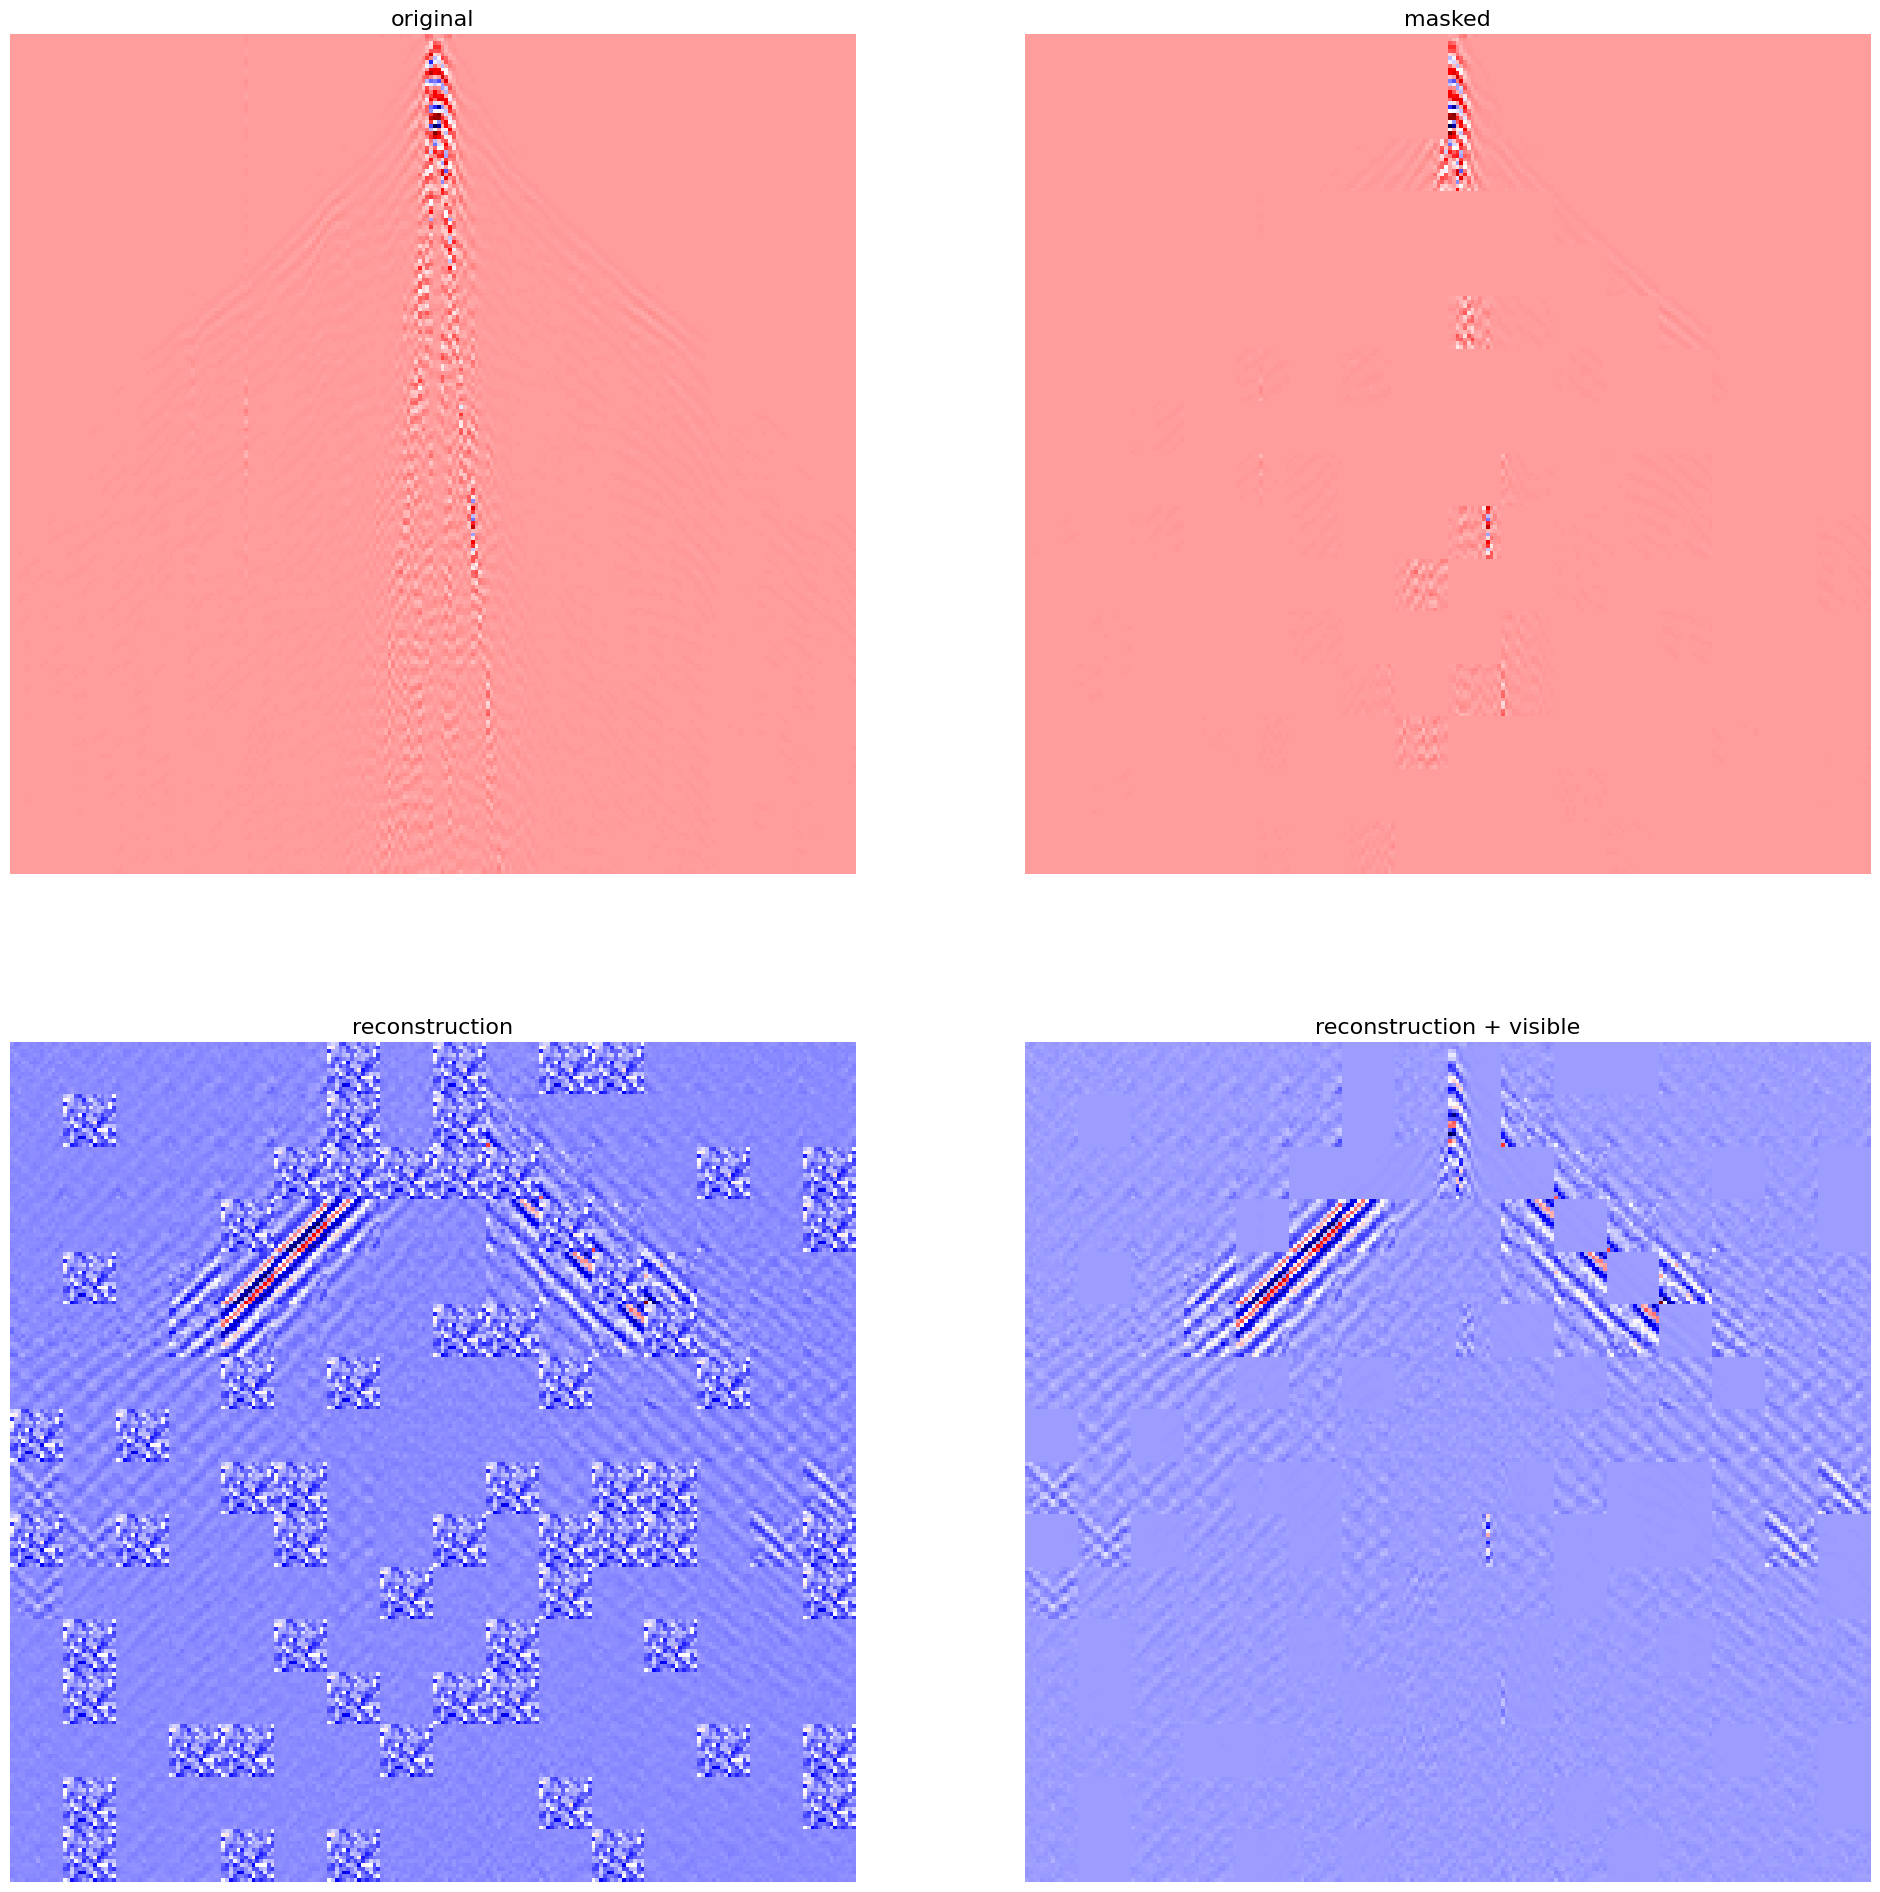

Validation batch shape: torch.Size([1, 3, 224, 224]) Indices: tensor([242])
MAE with pixel reconstruction:


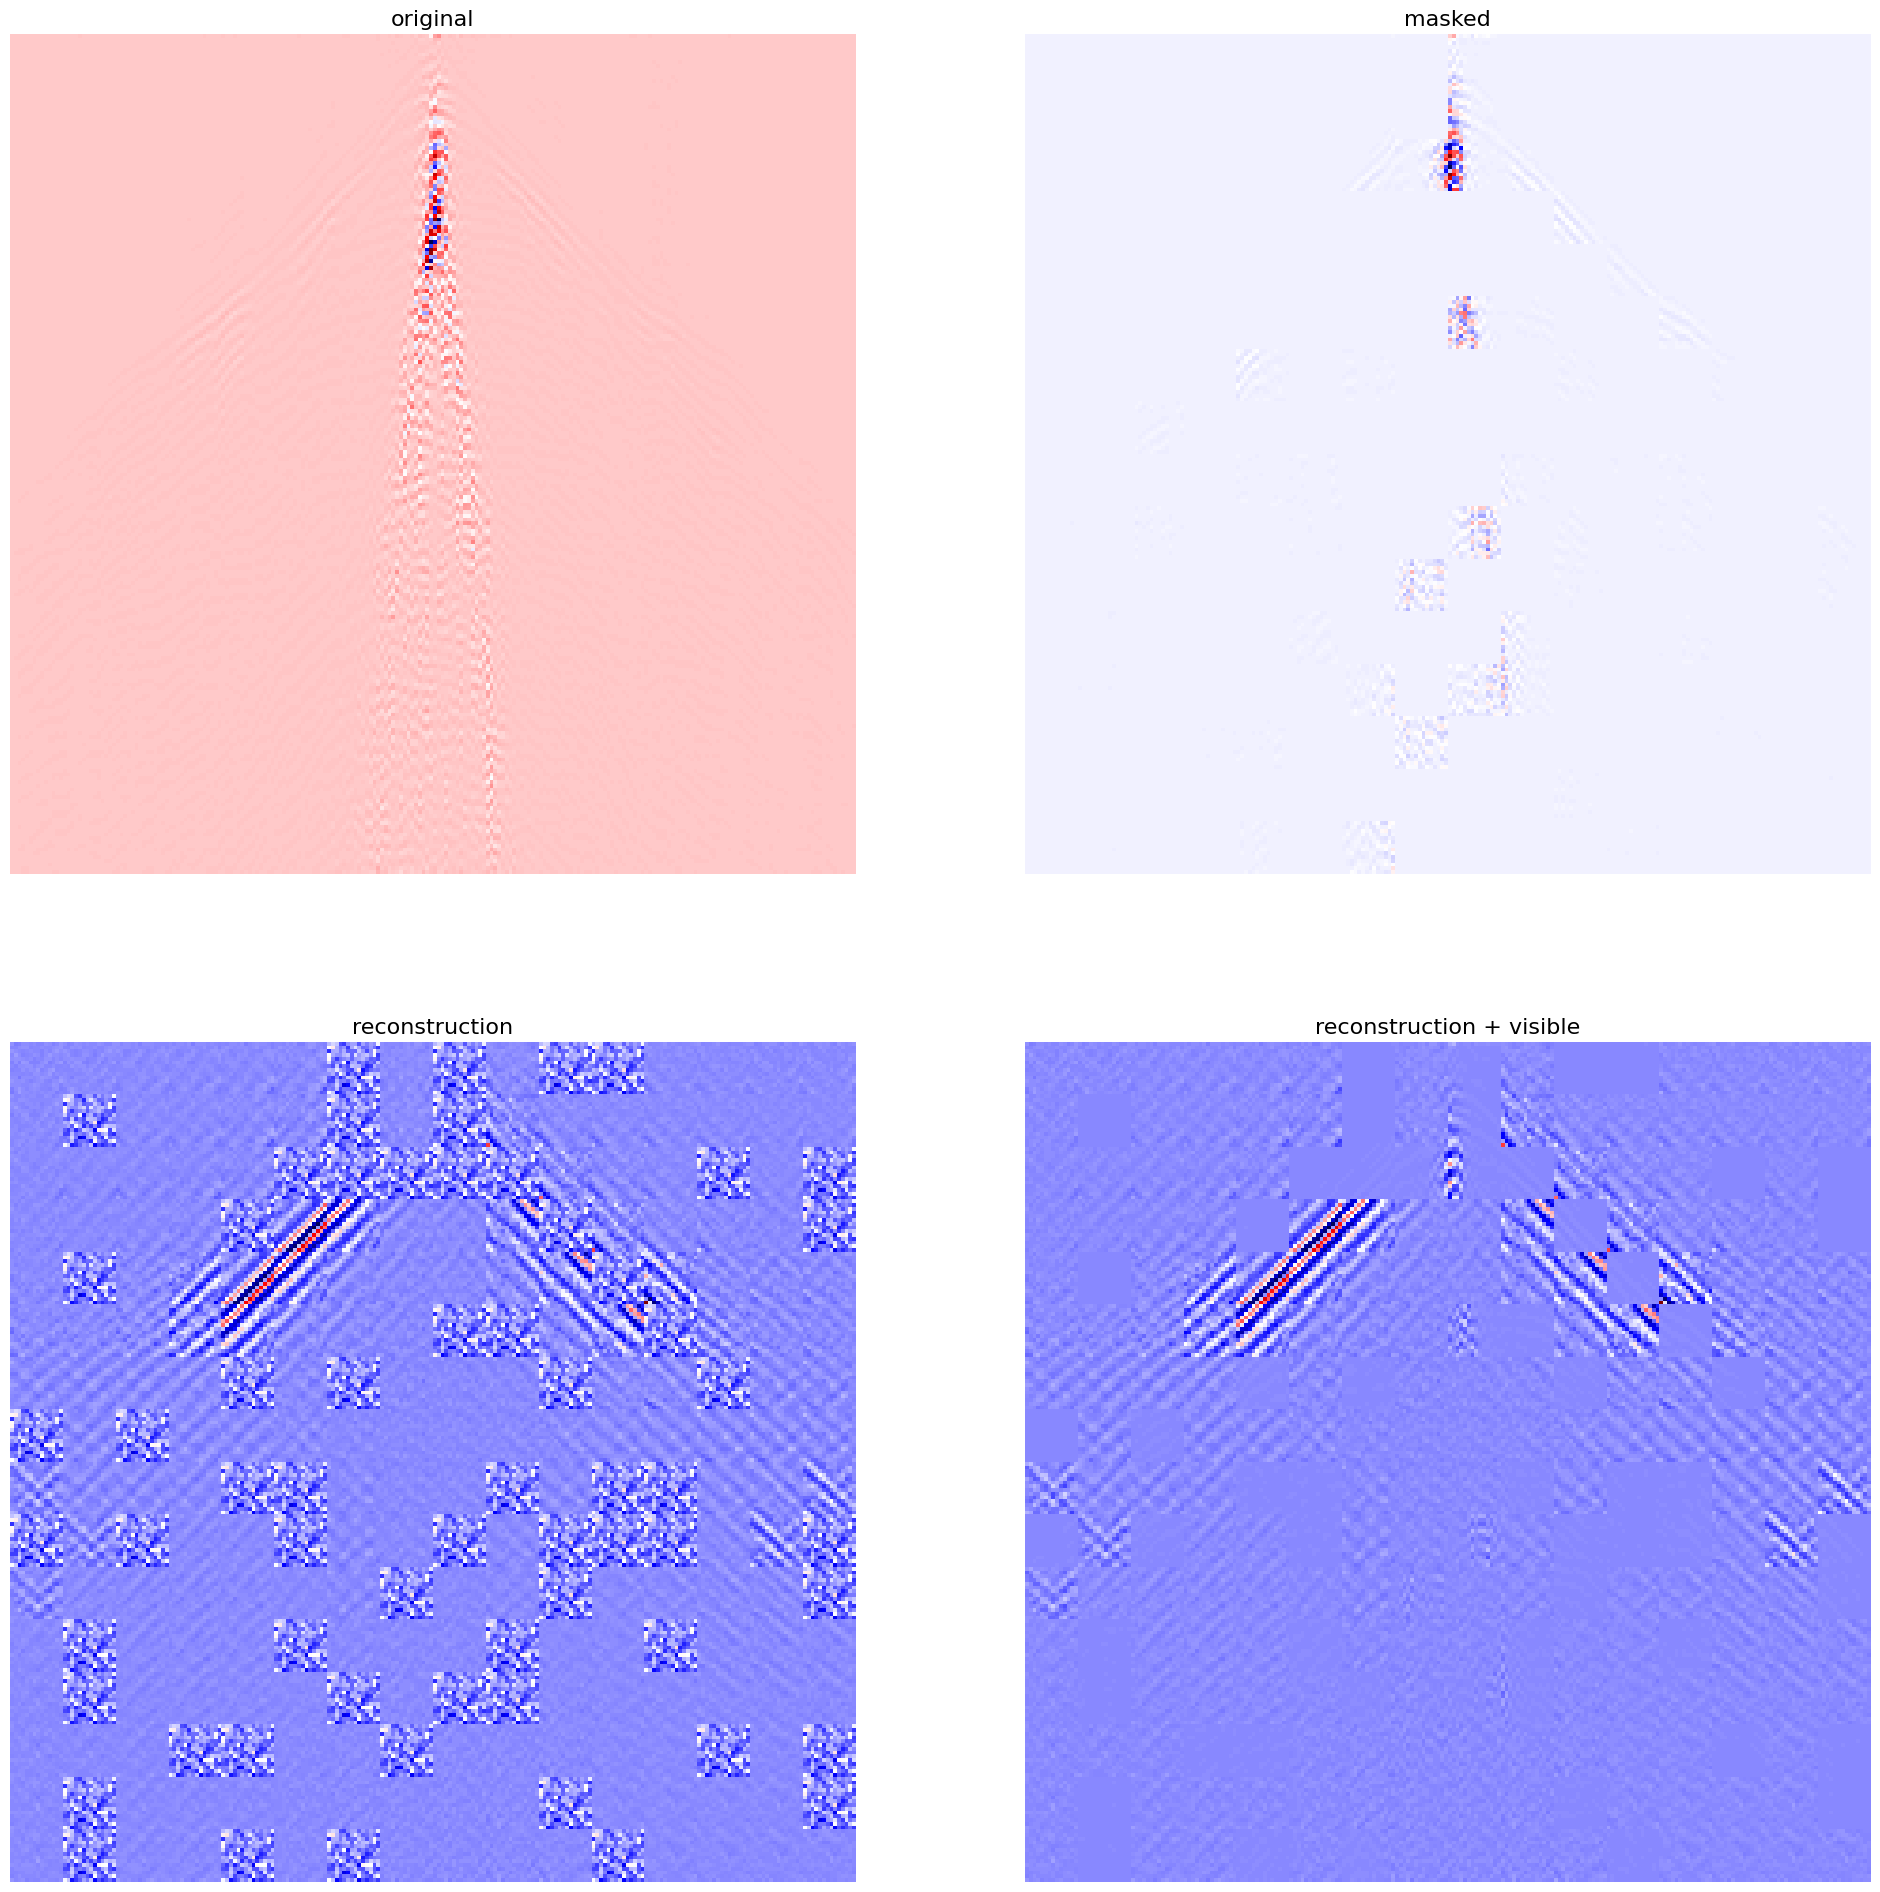

Validation batch shape: torch.Size([1, 3, 224, 224]) Indices: tensor([14])
MAE with pixel reconstruction:


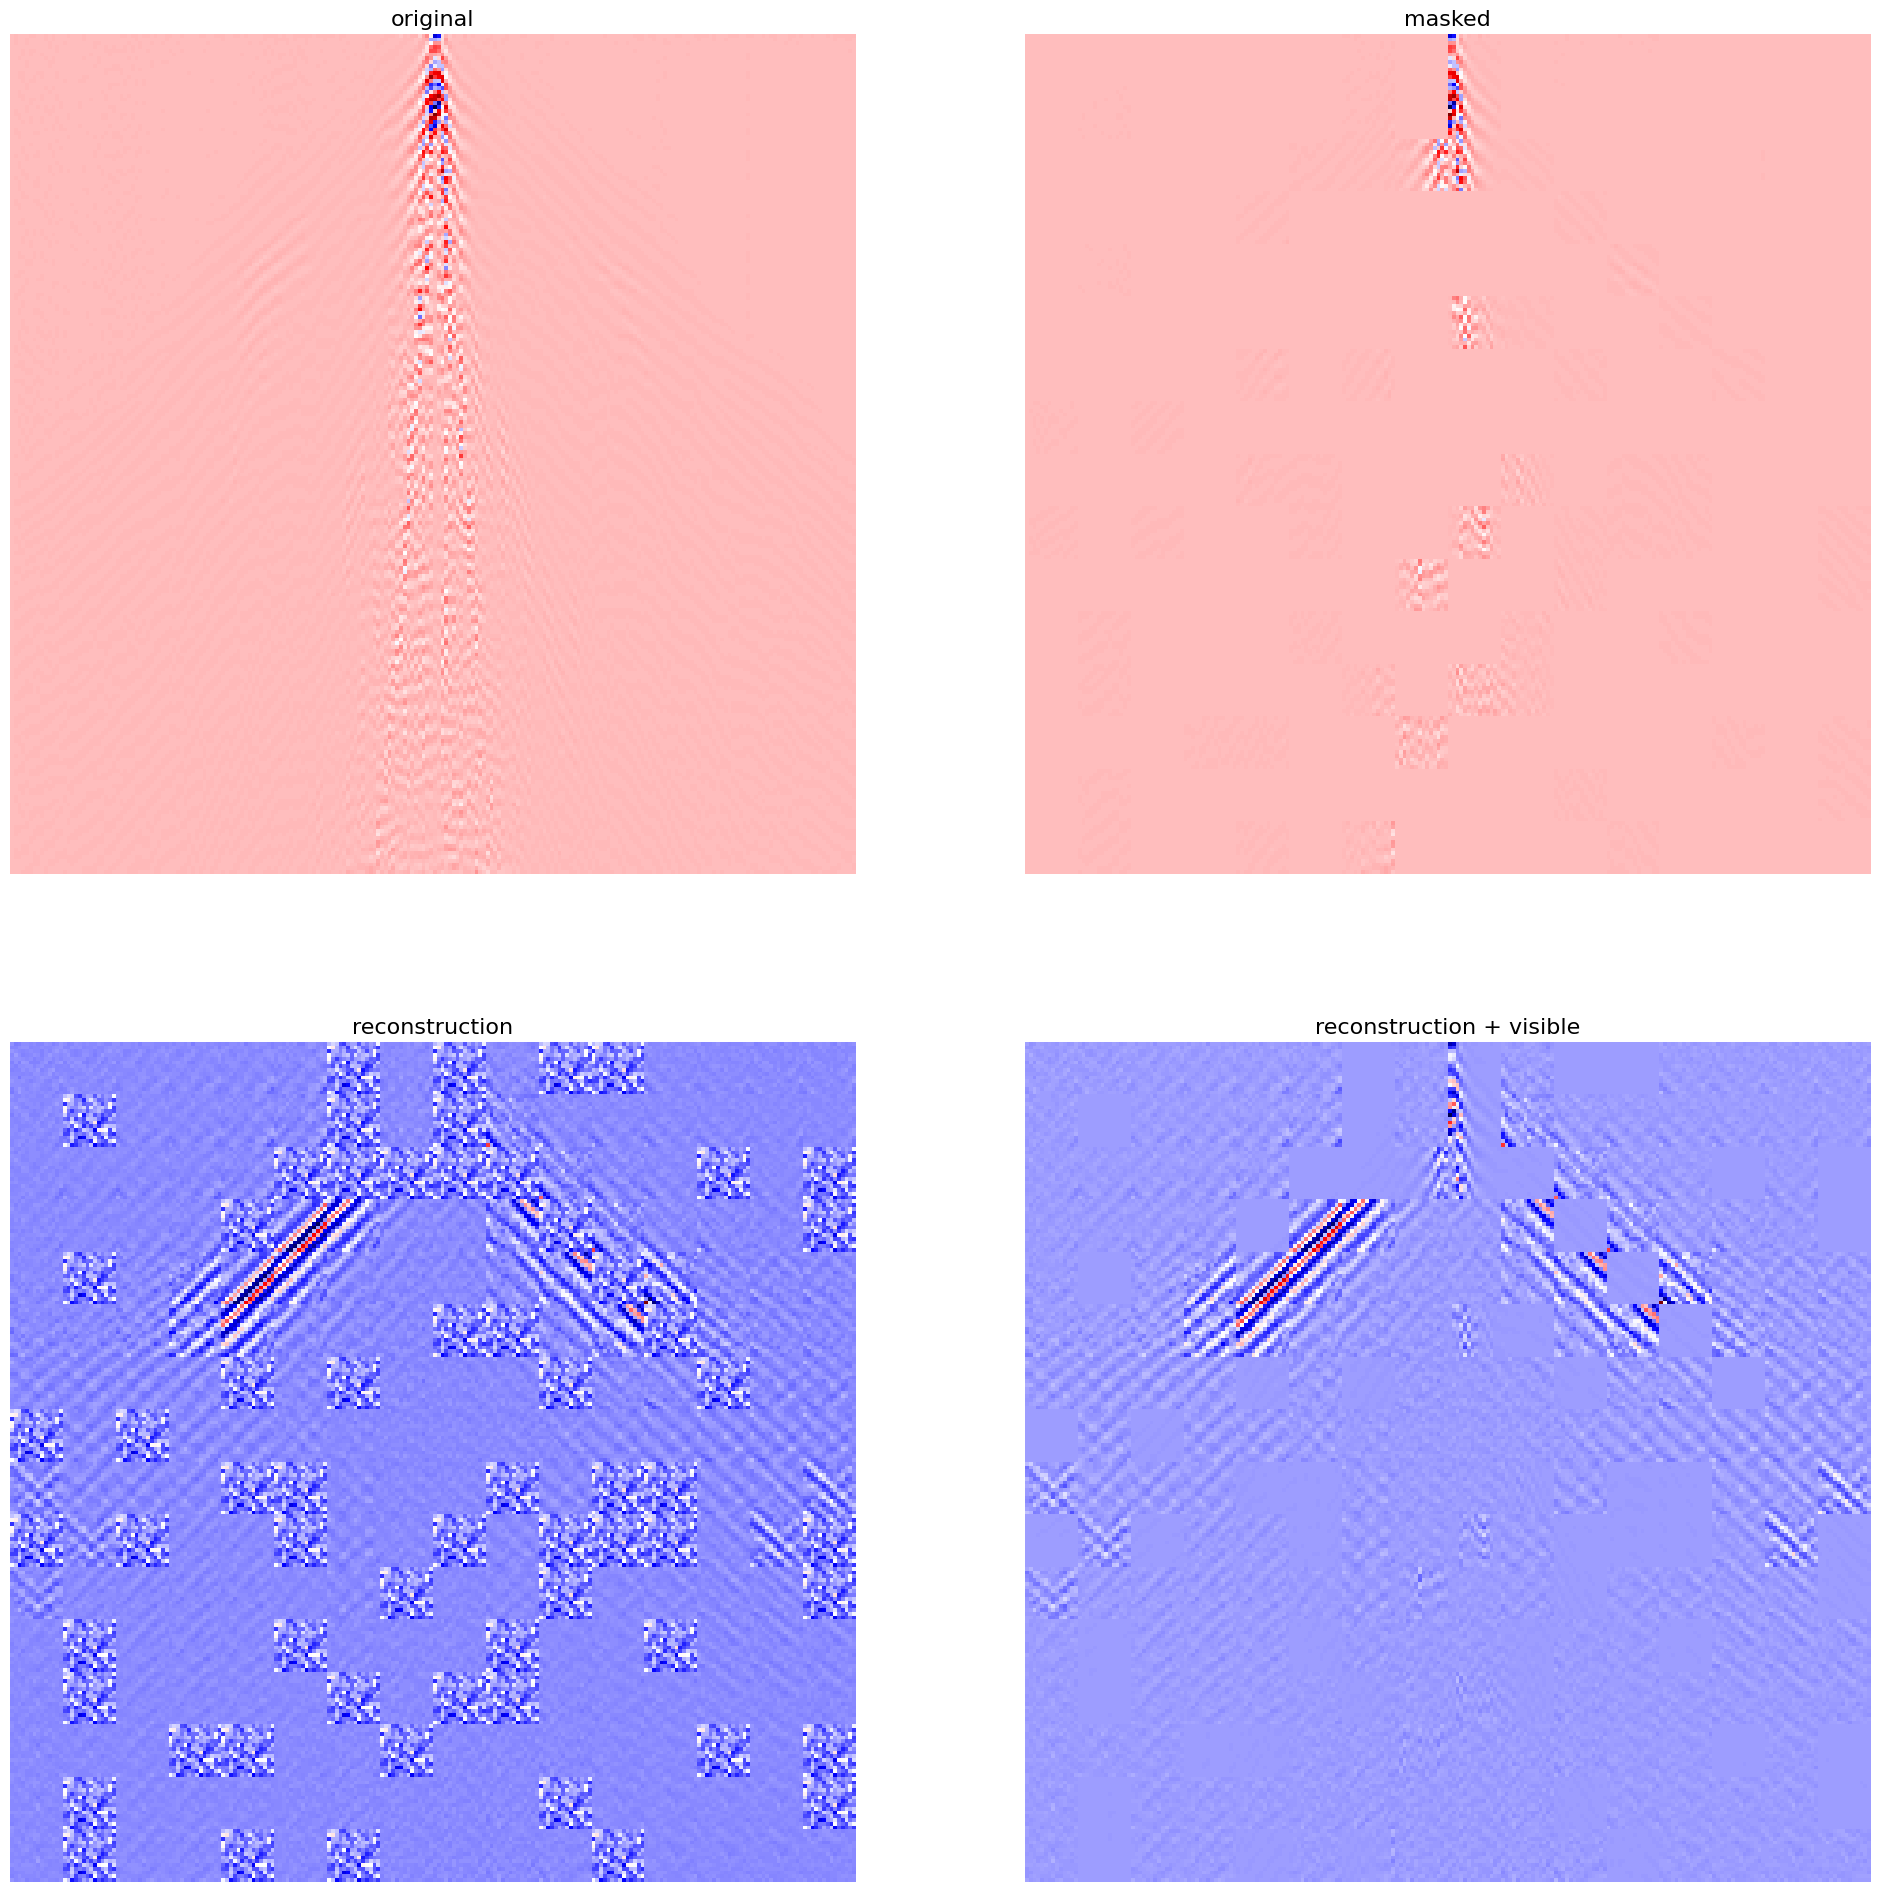

Validation batch shape: torch.Size([1, 3, 224, 224]) Indices: tensor([71])
MAE with pixel reconstruction:


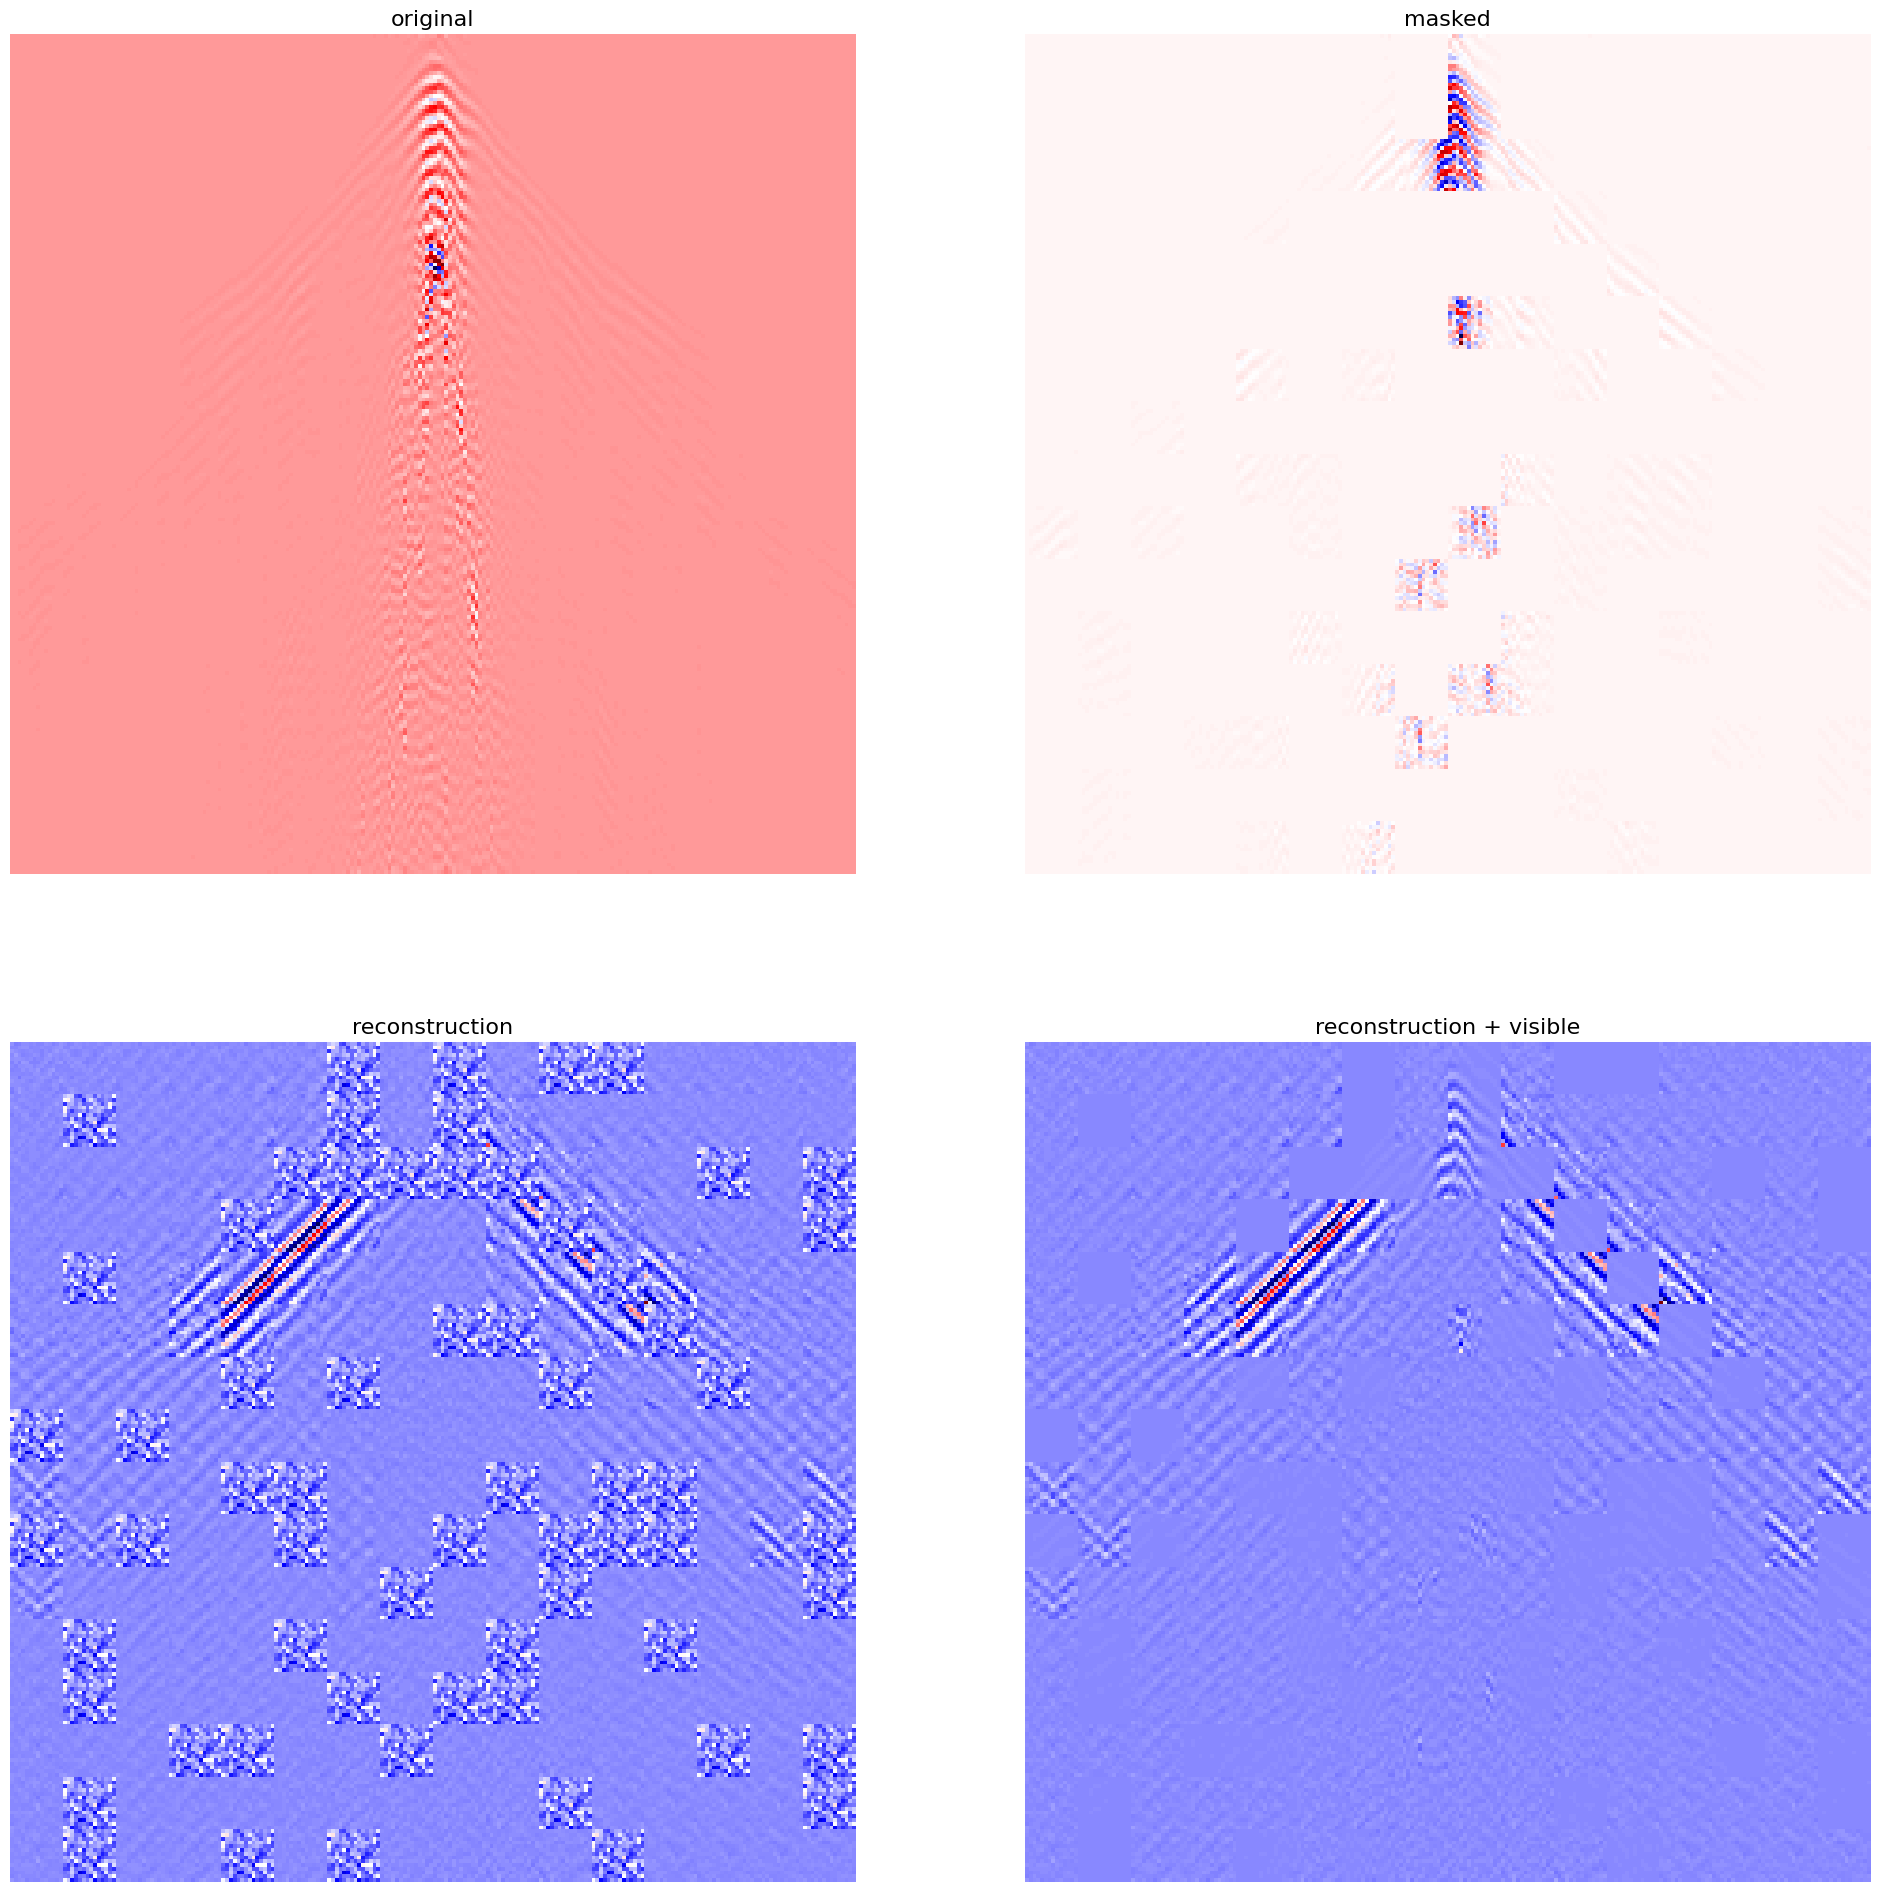

Validation batch shape: torch.Size([1, 3, 224, 224]) Indices: tensor([116])
MAE with pixel reconstruction:


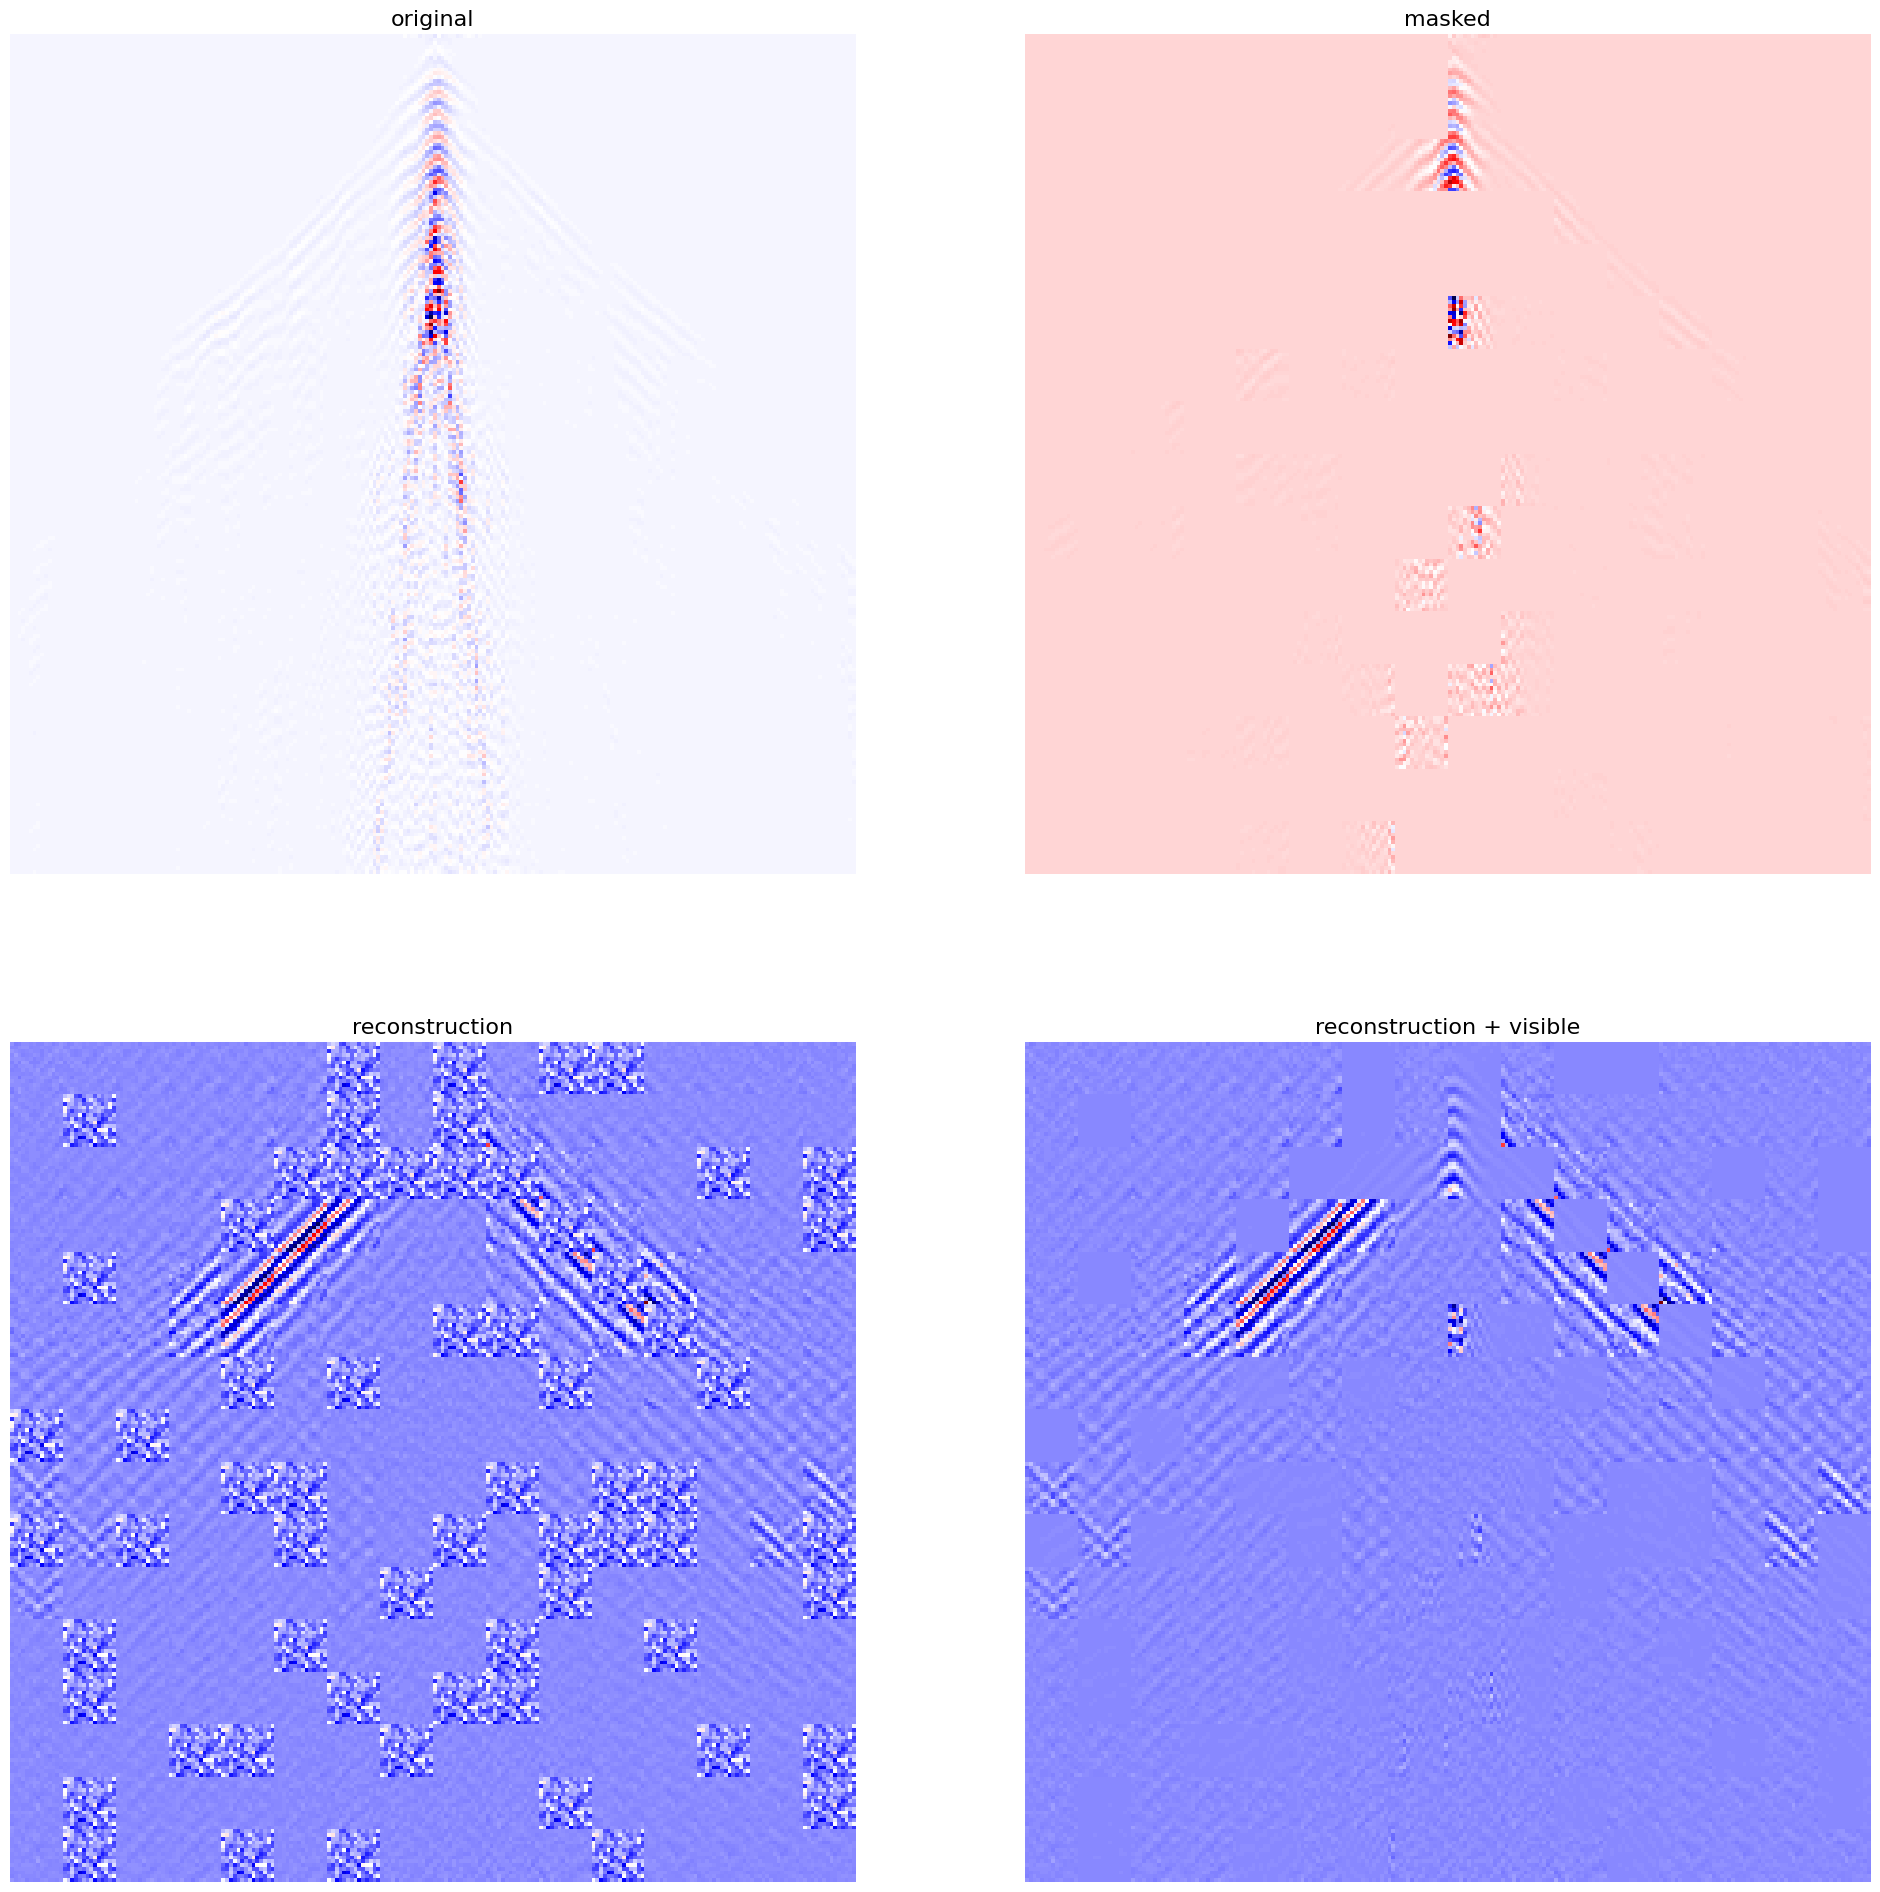

Validation batch shape: torch.Size([1, 3, 224, 224]) Indices: tensor([31])
MAE with pixel reconstruction:


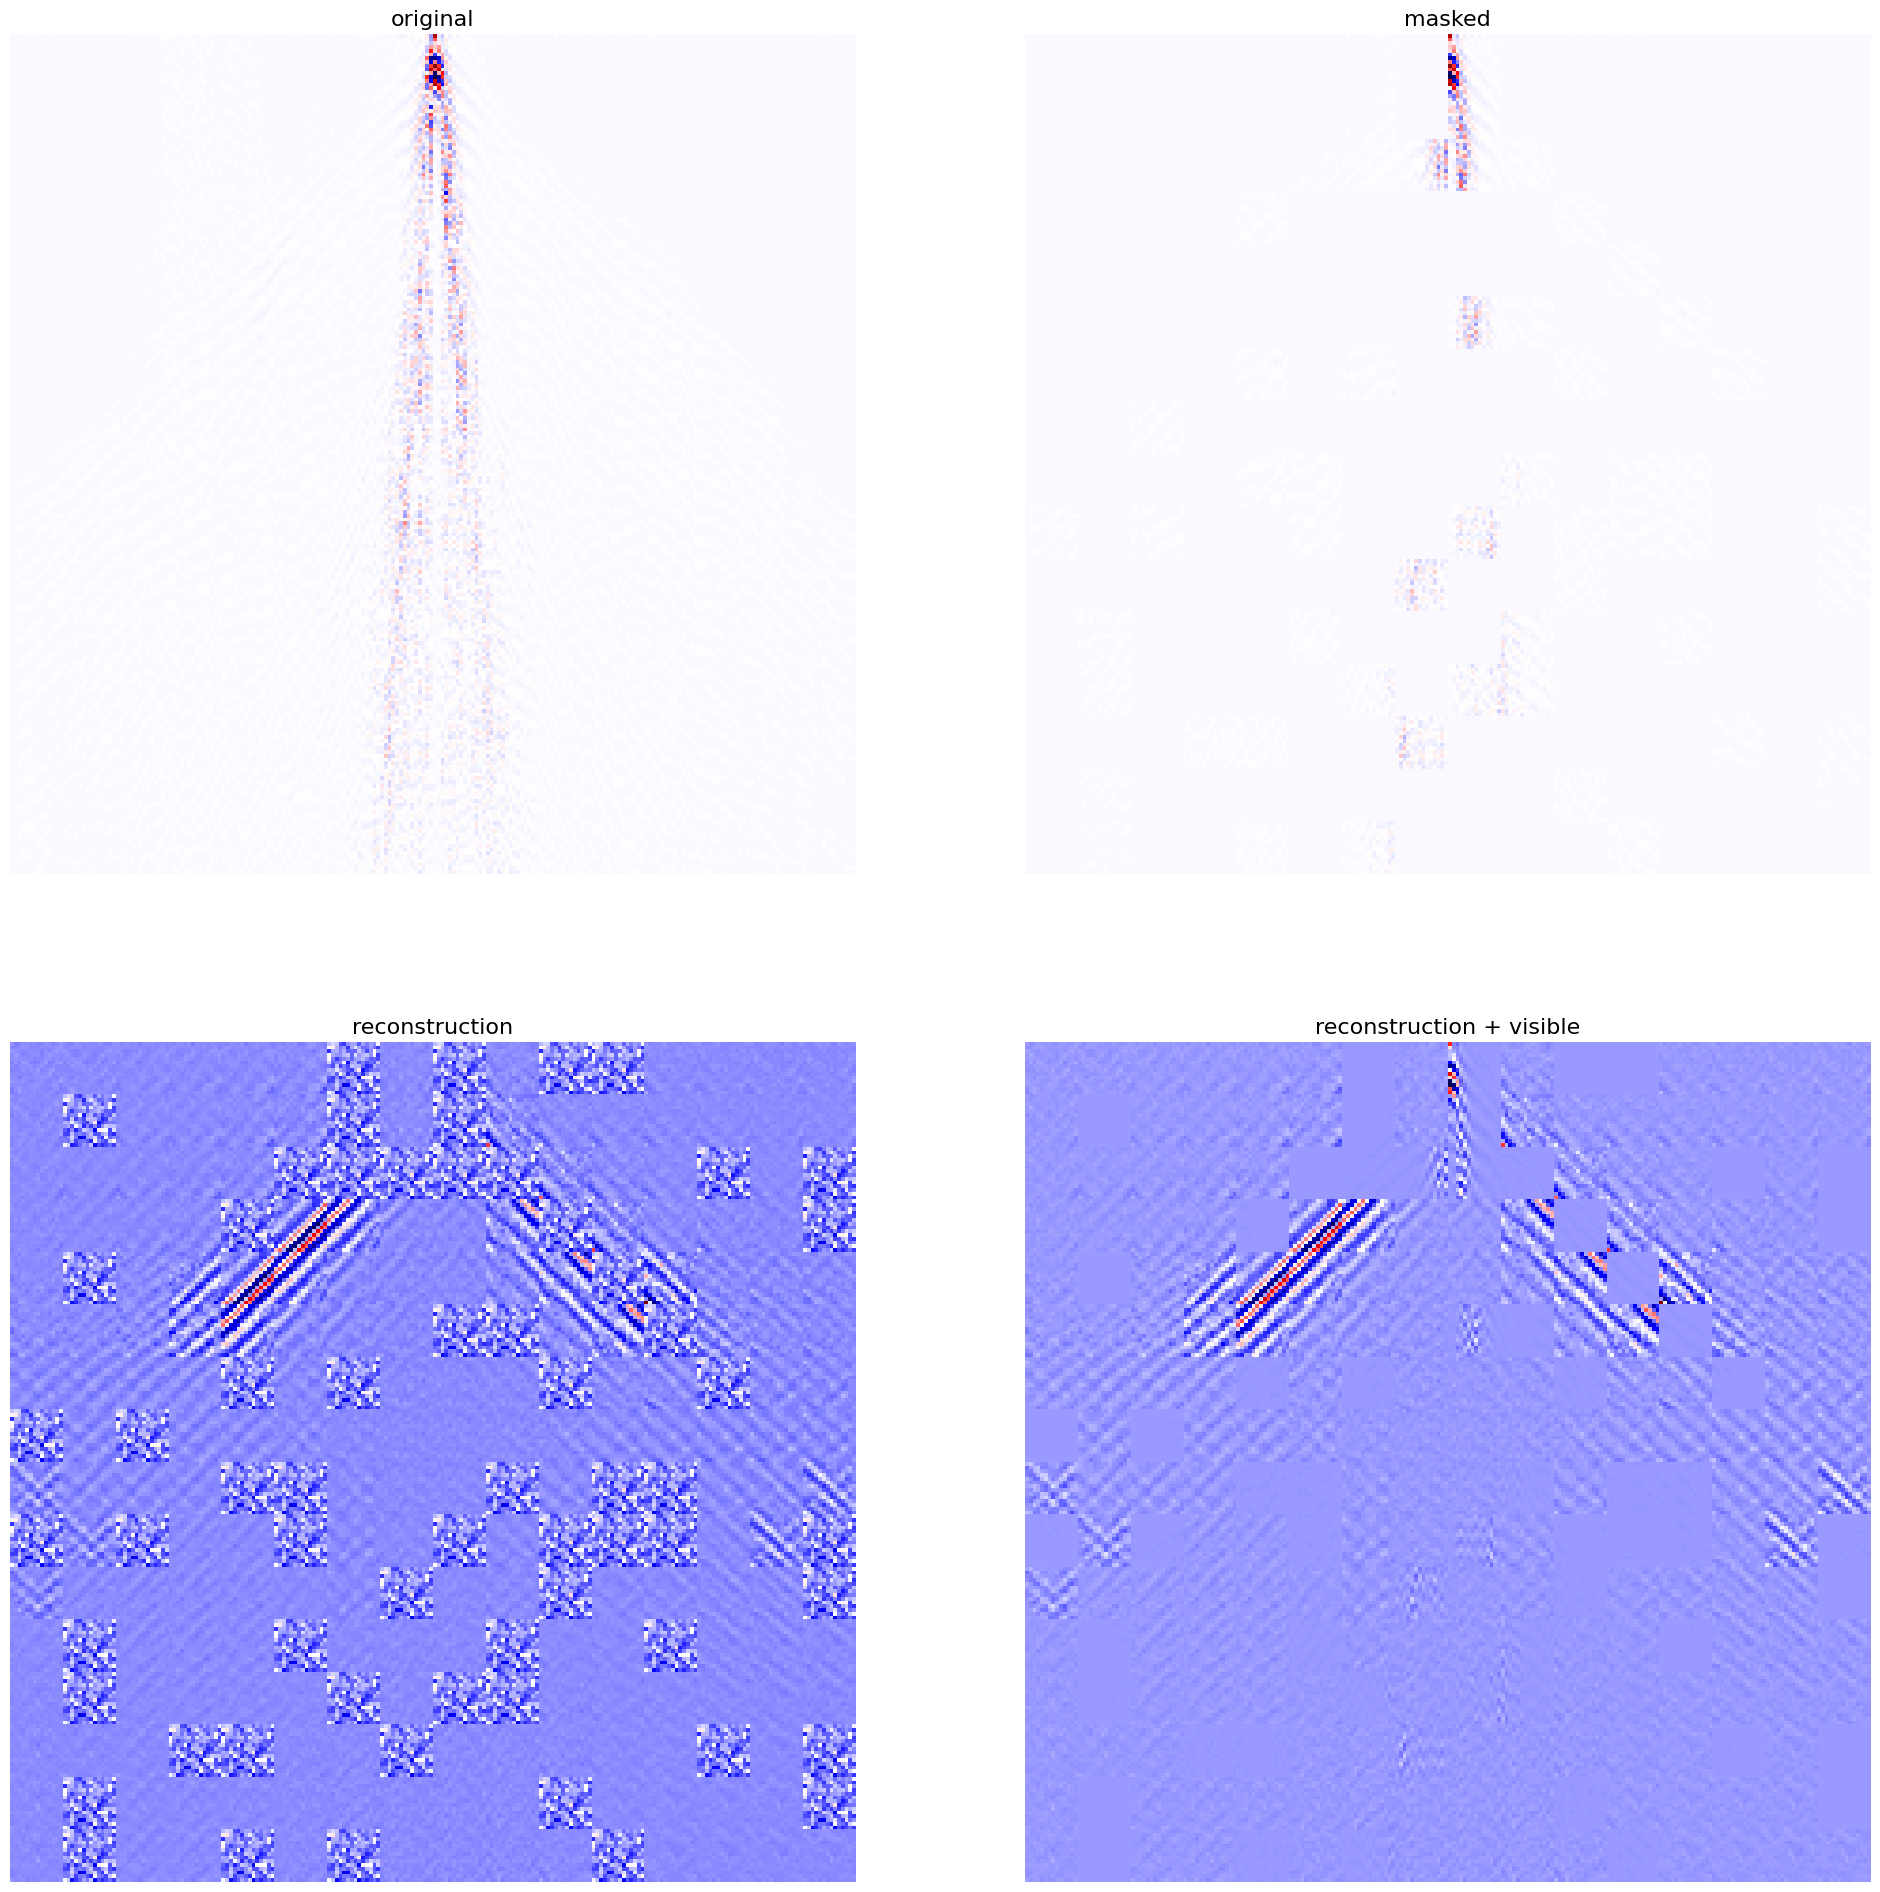

Validation batch shape: torch.Size([1, 3, 224, 224]) Indices: tensor([237])
MAE with pixel reconstruction:


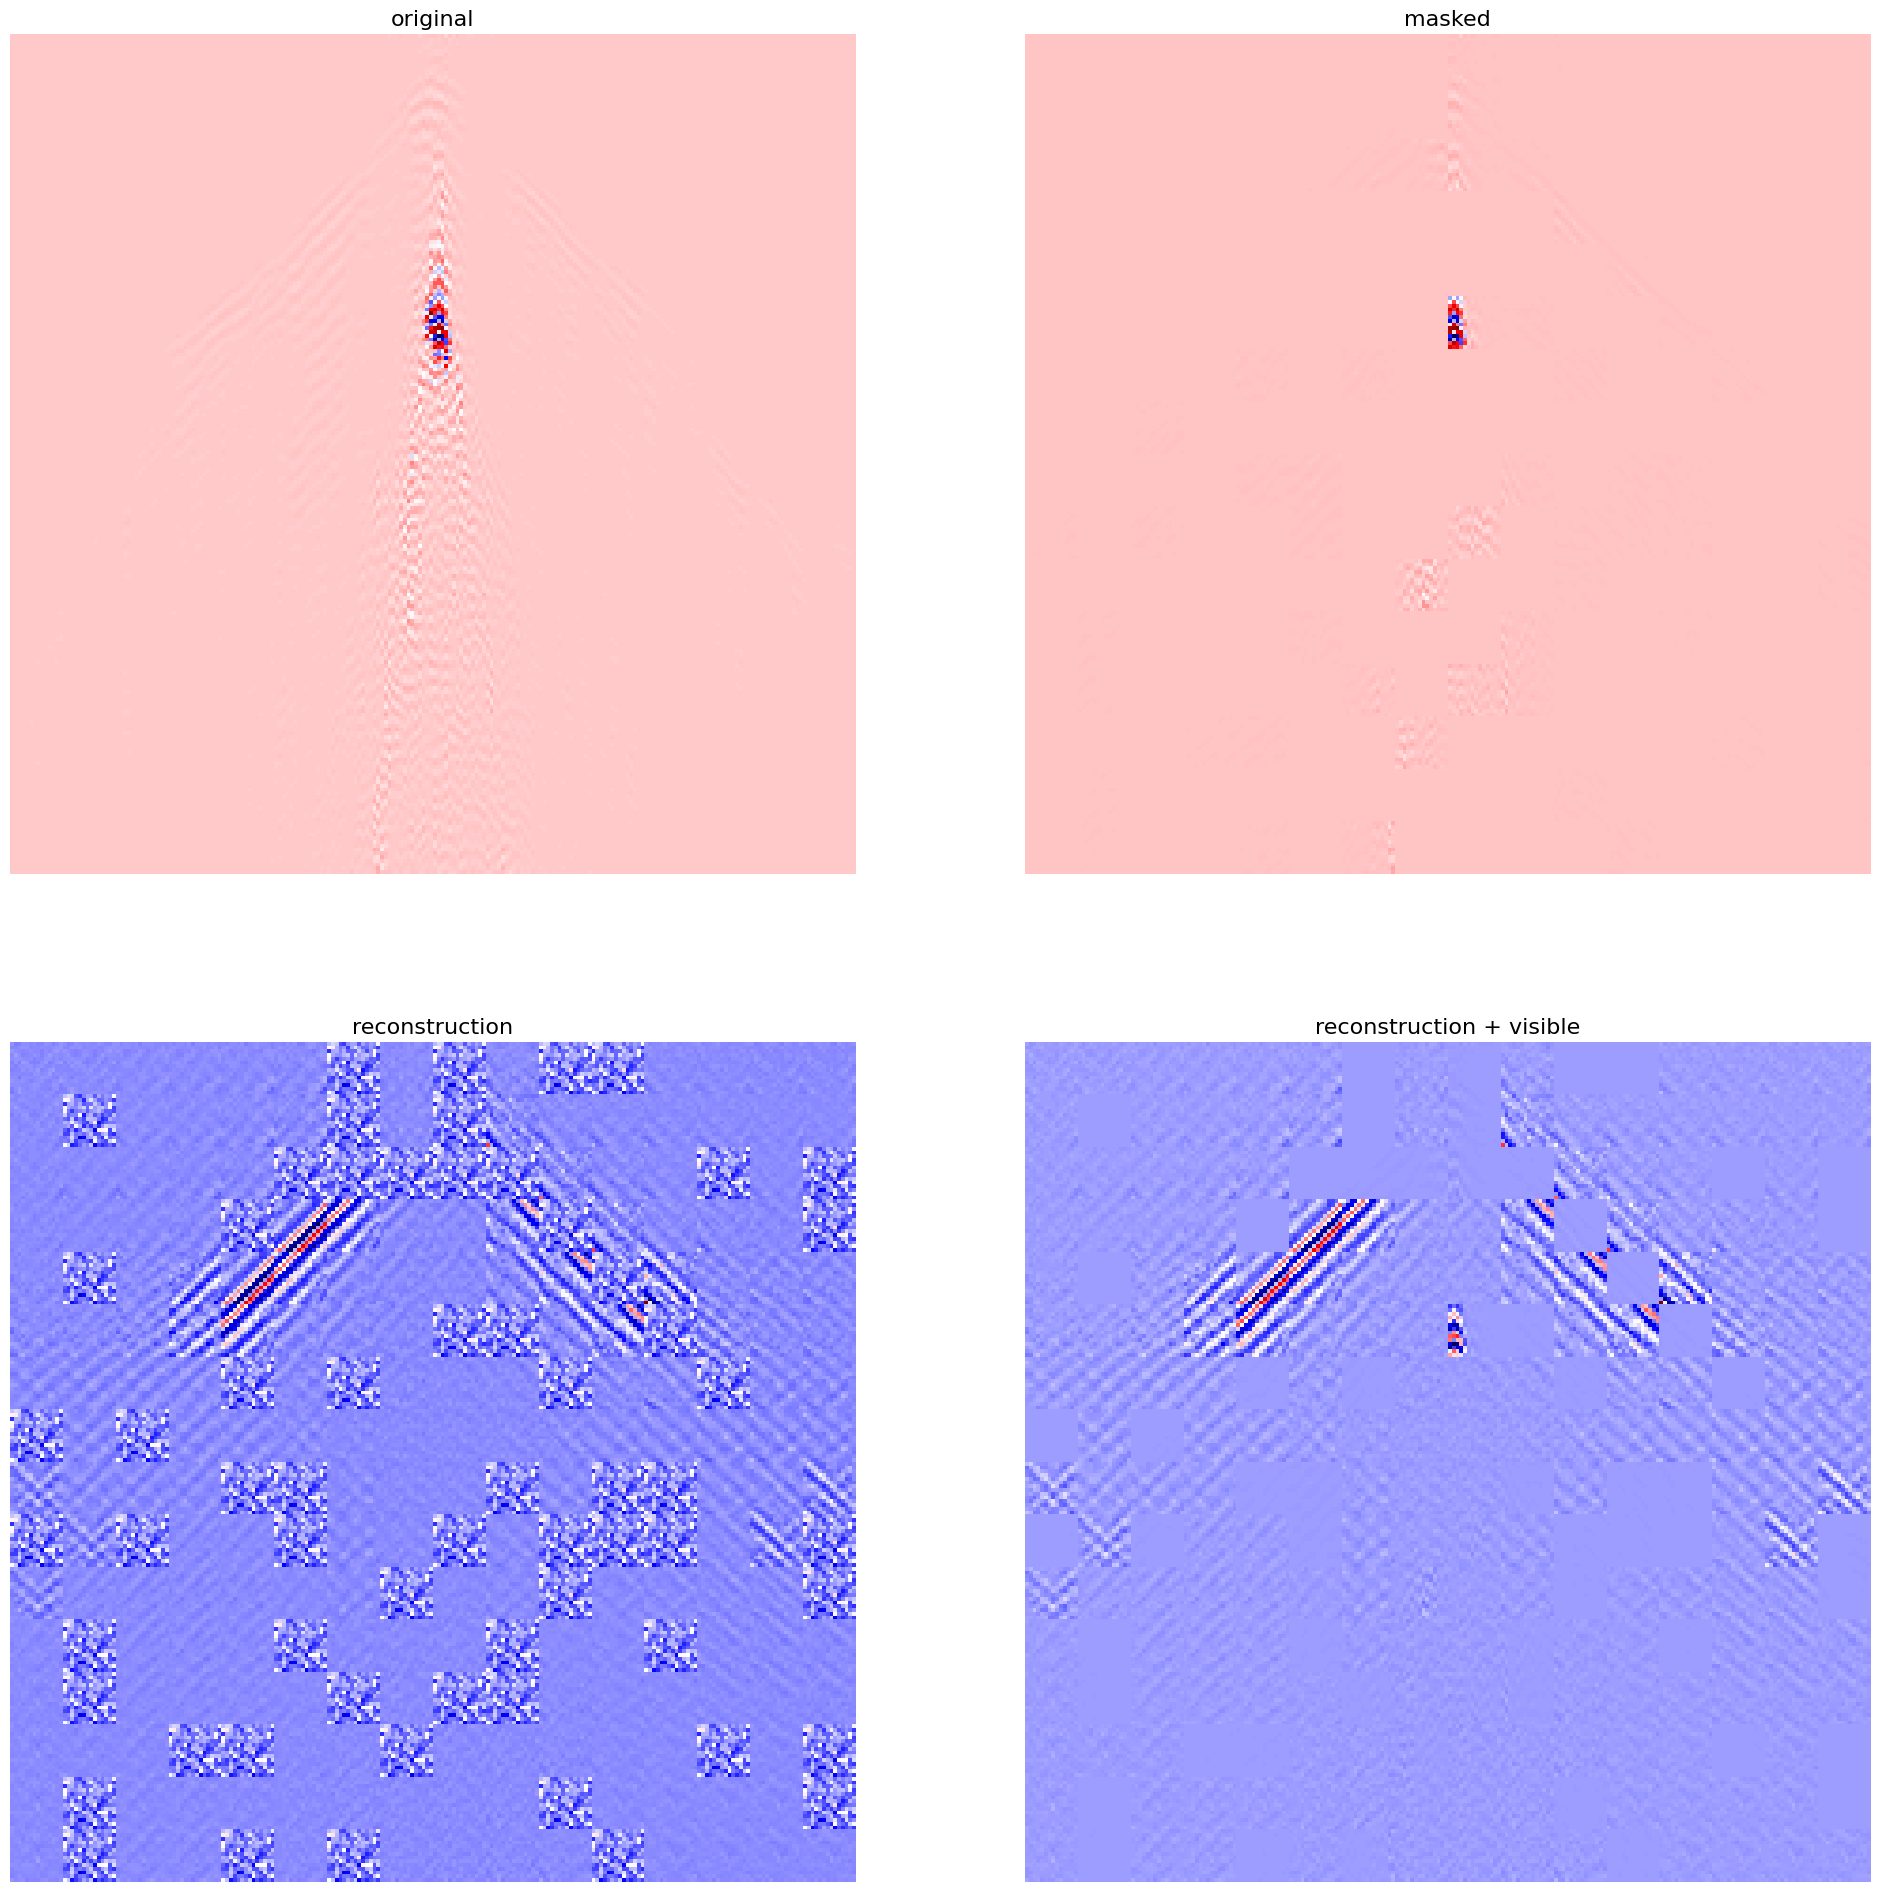

Validation batch shape: torch.Size([1, 3, 224, 224]) Indices: tensor([156])
MAE with pixel reconstruction:


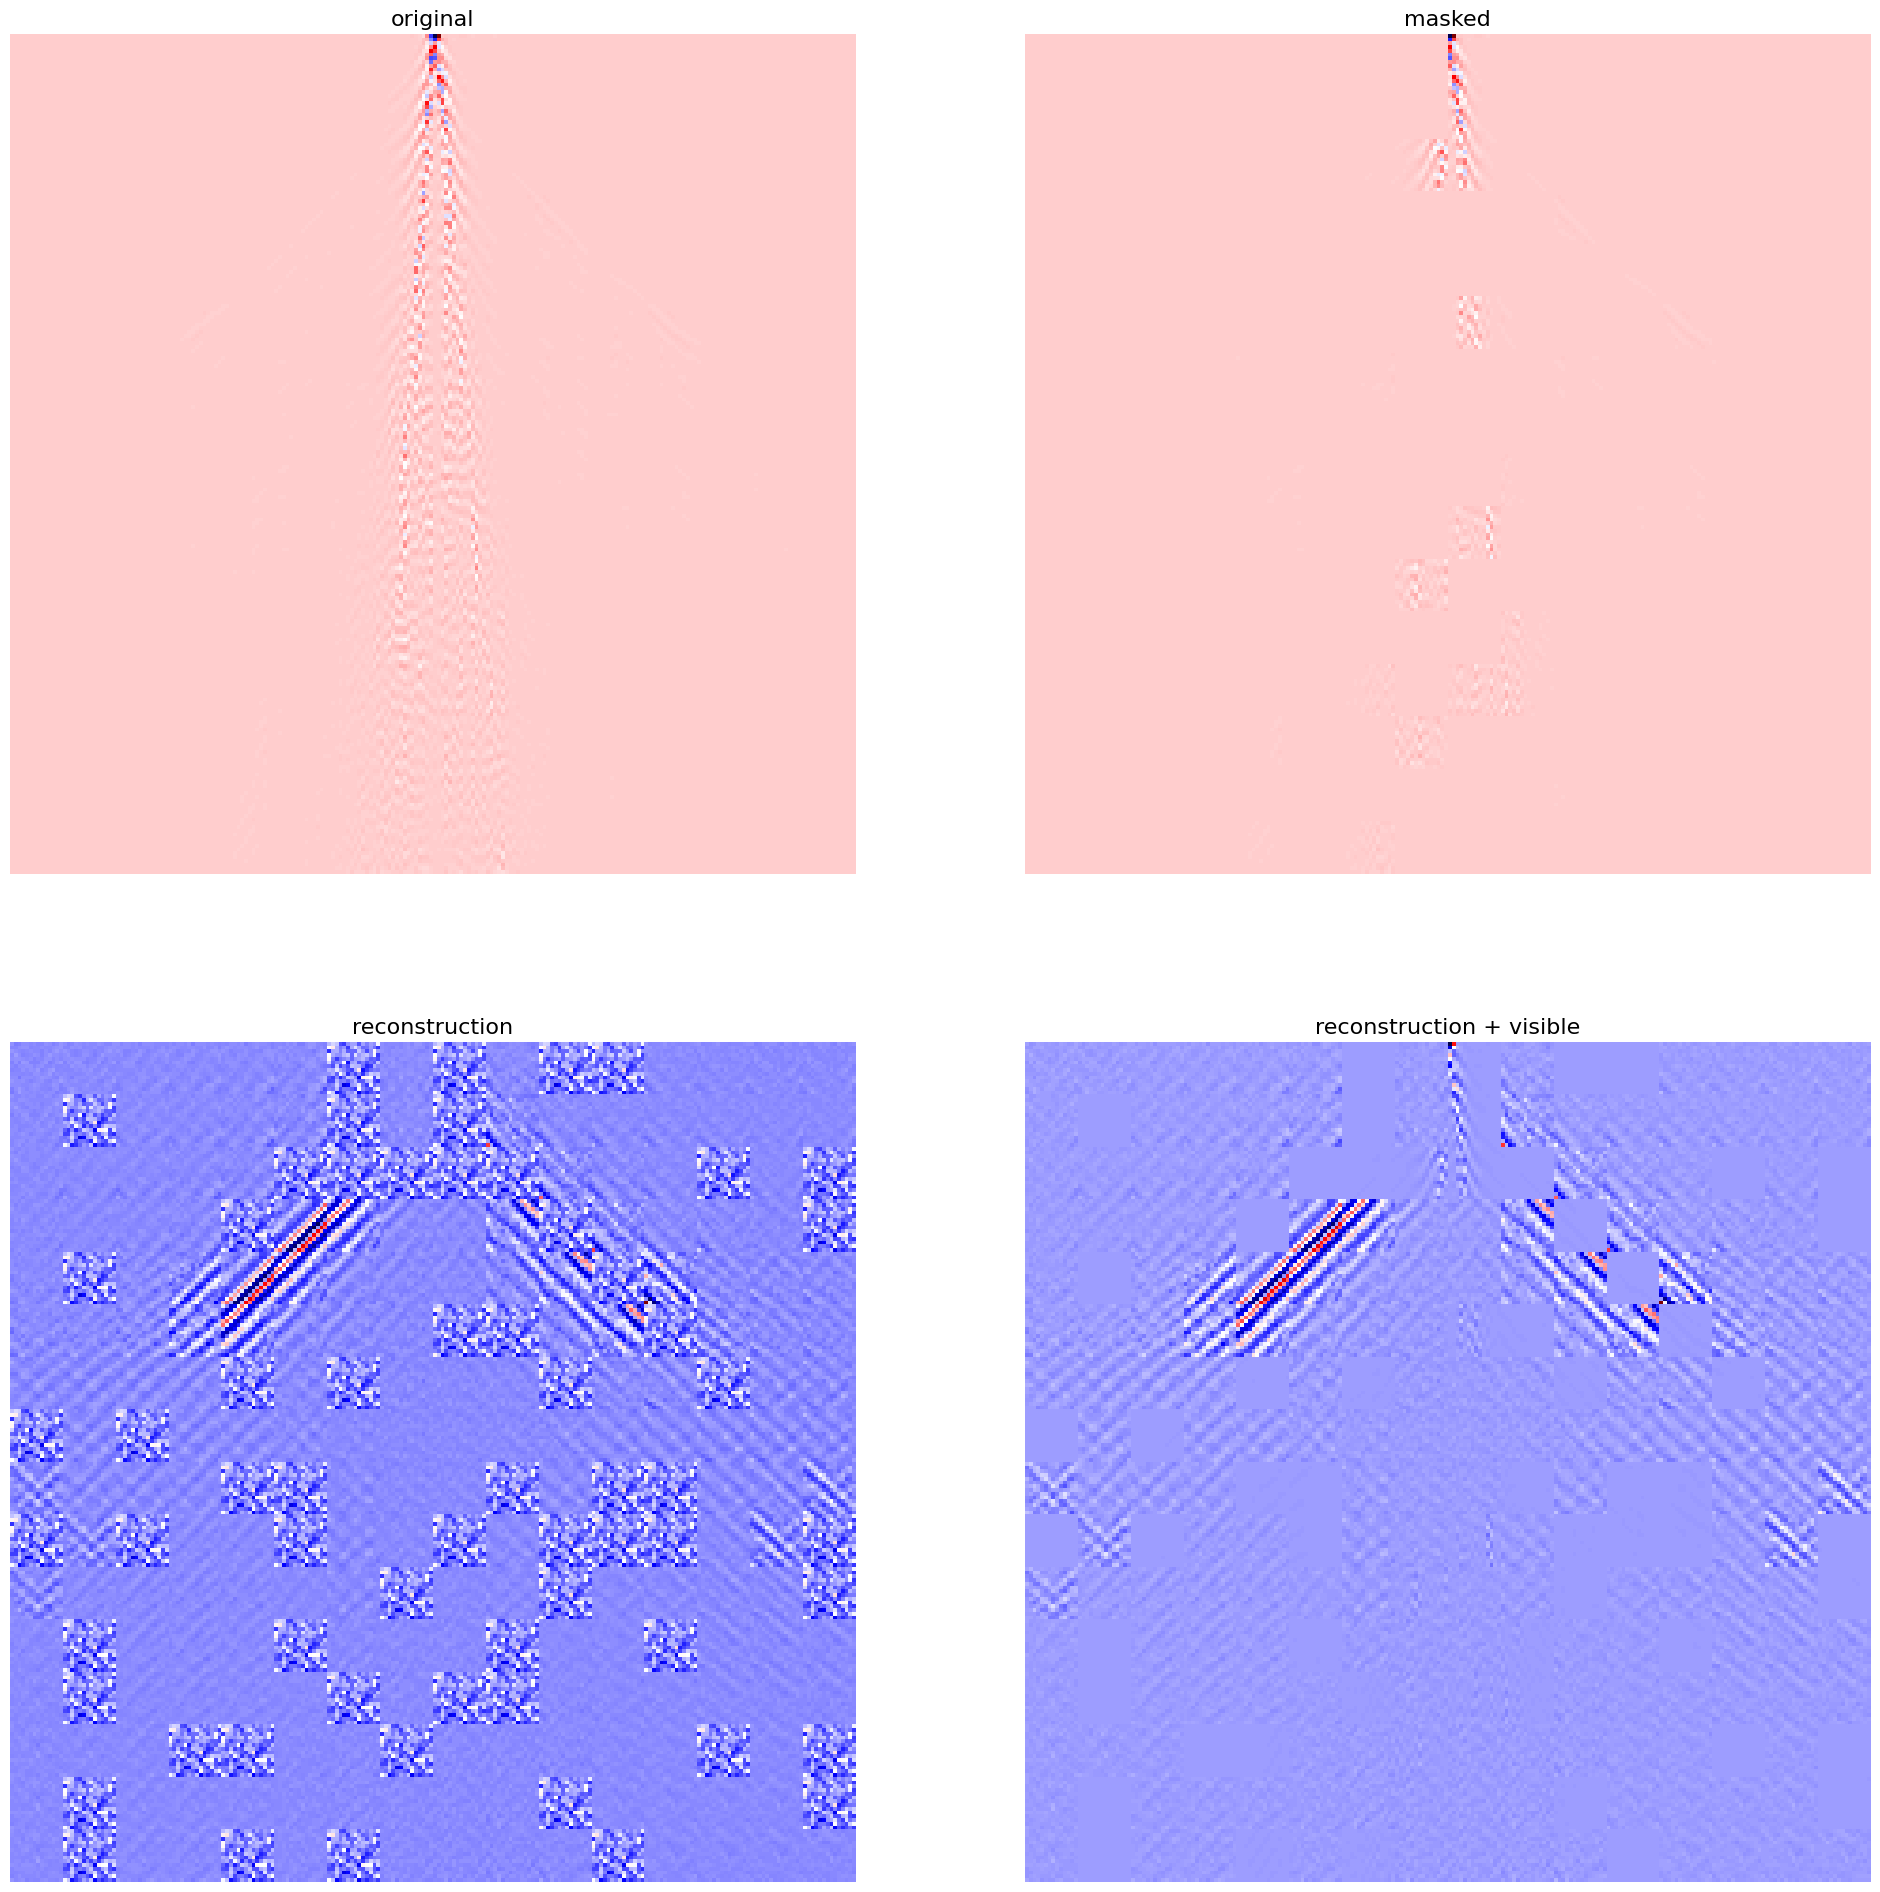

Validation batch shape: torch.Size([1, 3, 224, 224]) Indices: tensor([192])
MAE with pixel reconstruction:


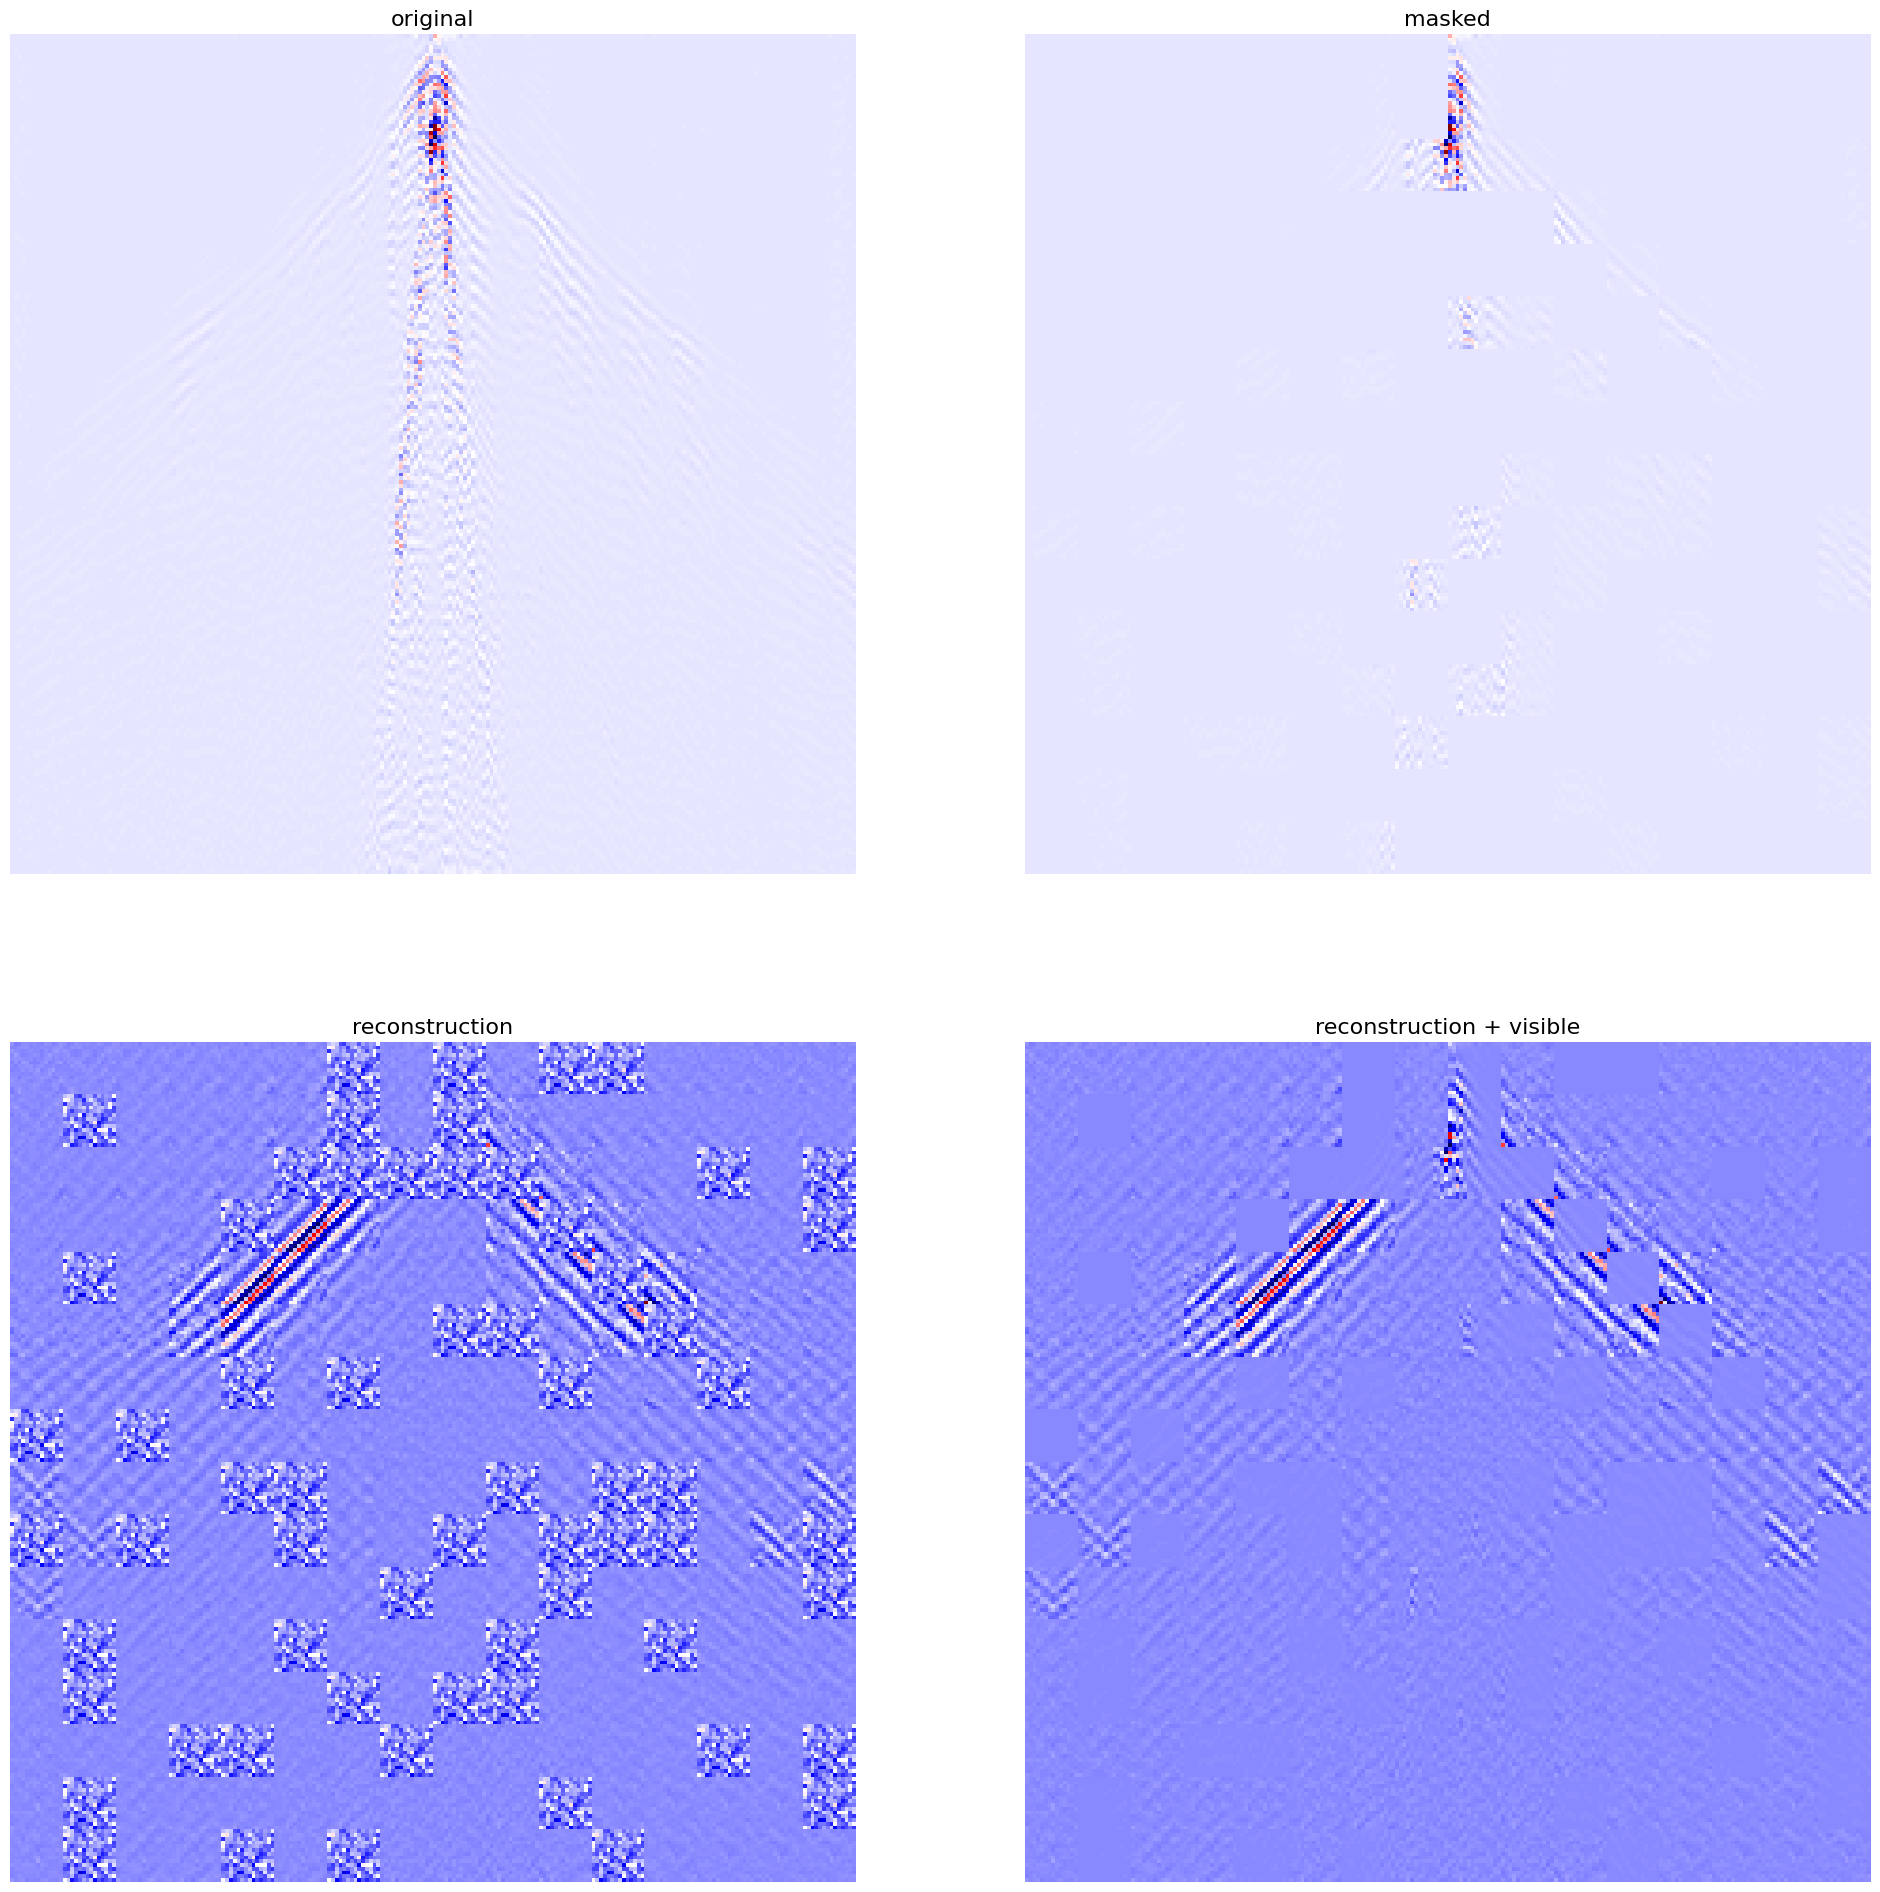

Validation batch shape: torch.Size([1, 3, 224, 224]) Indices: tensor([175])
MAE with pixel reconstruction:


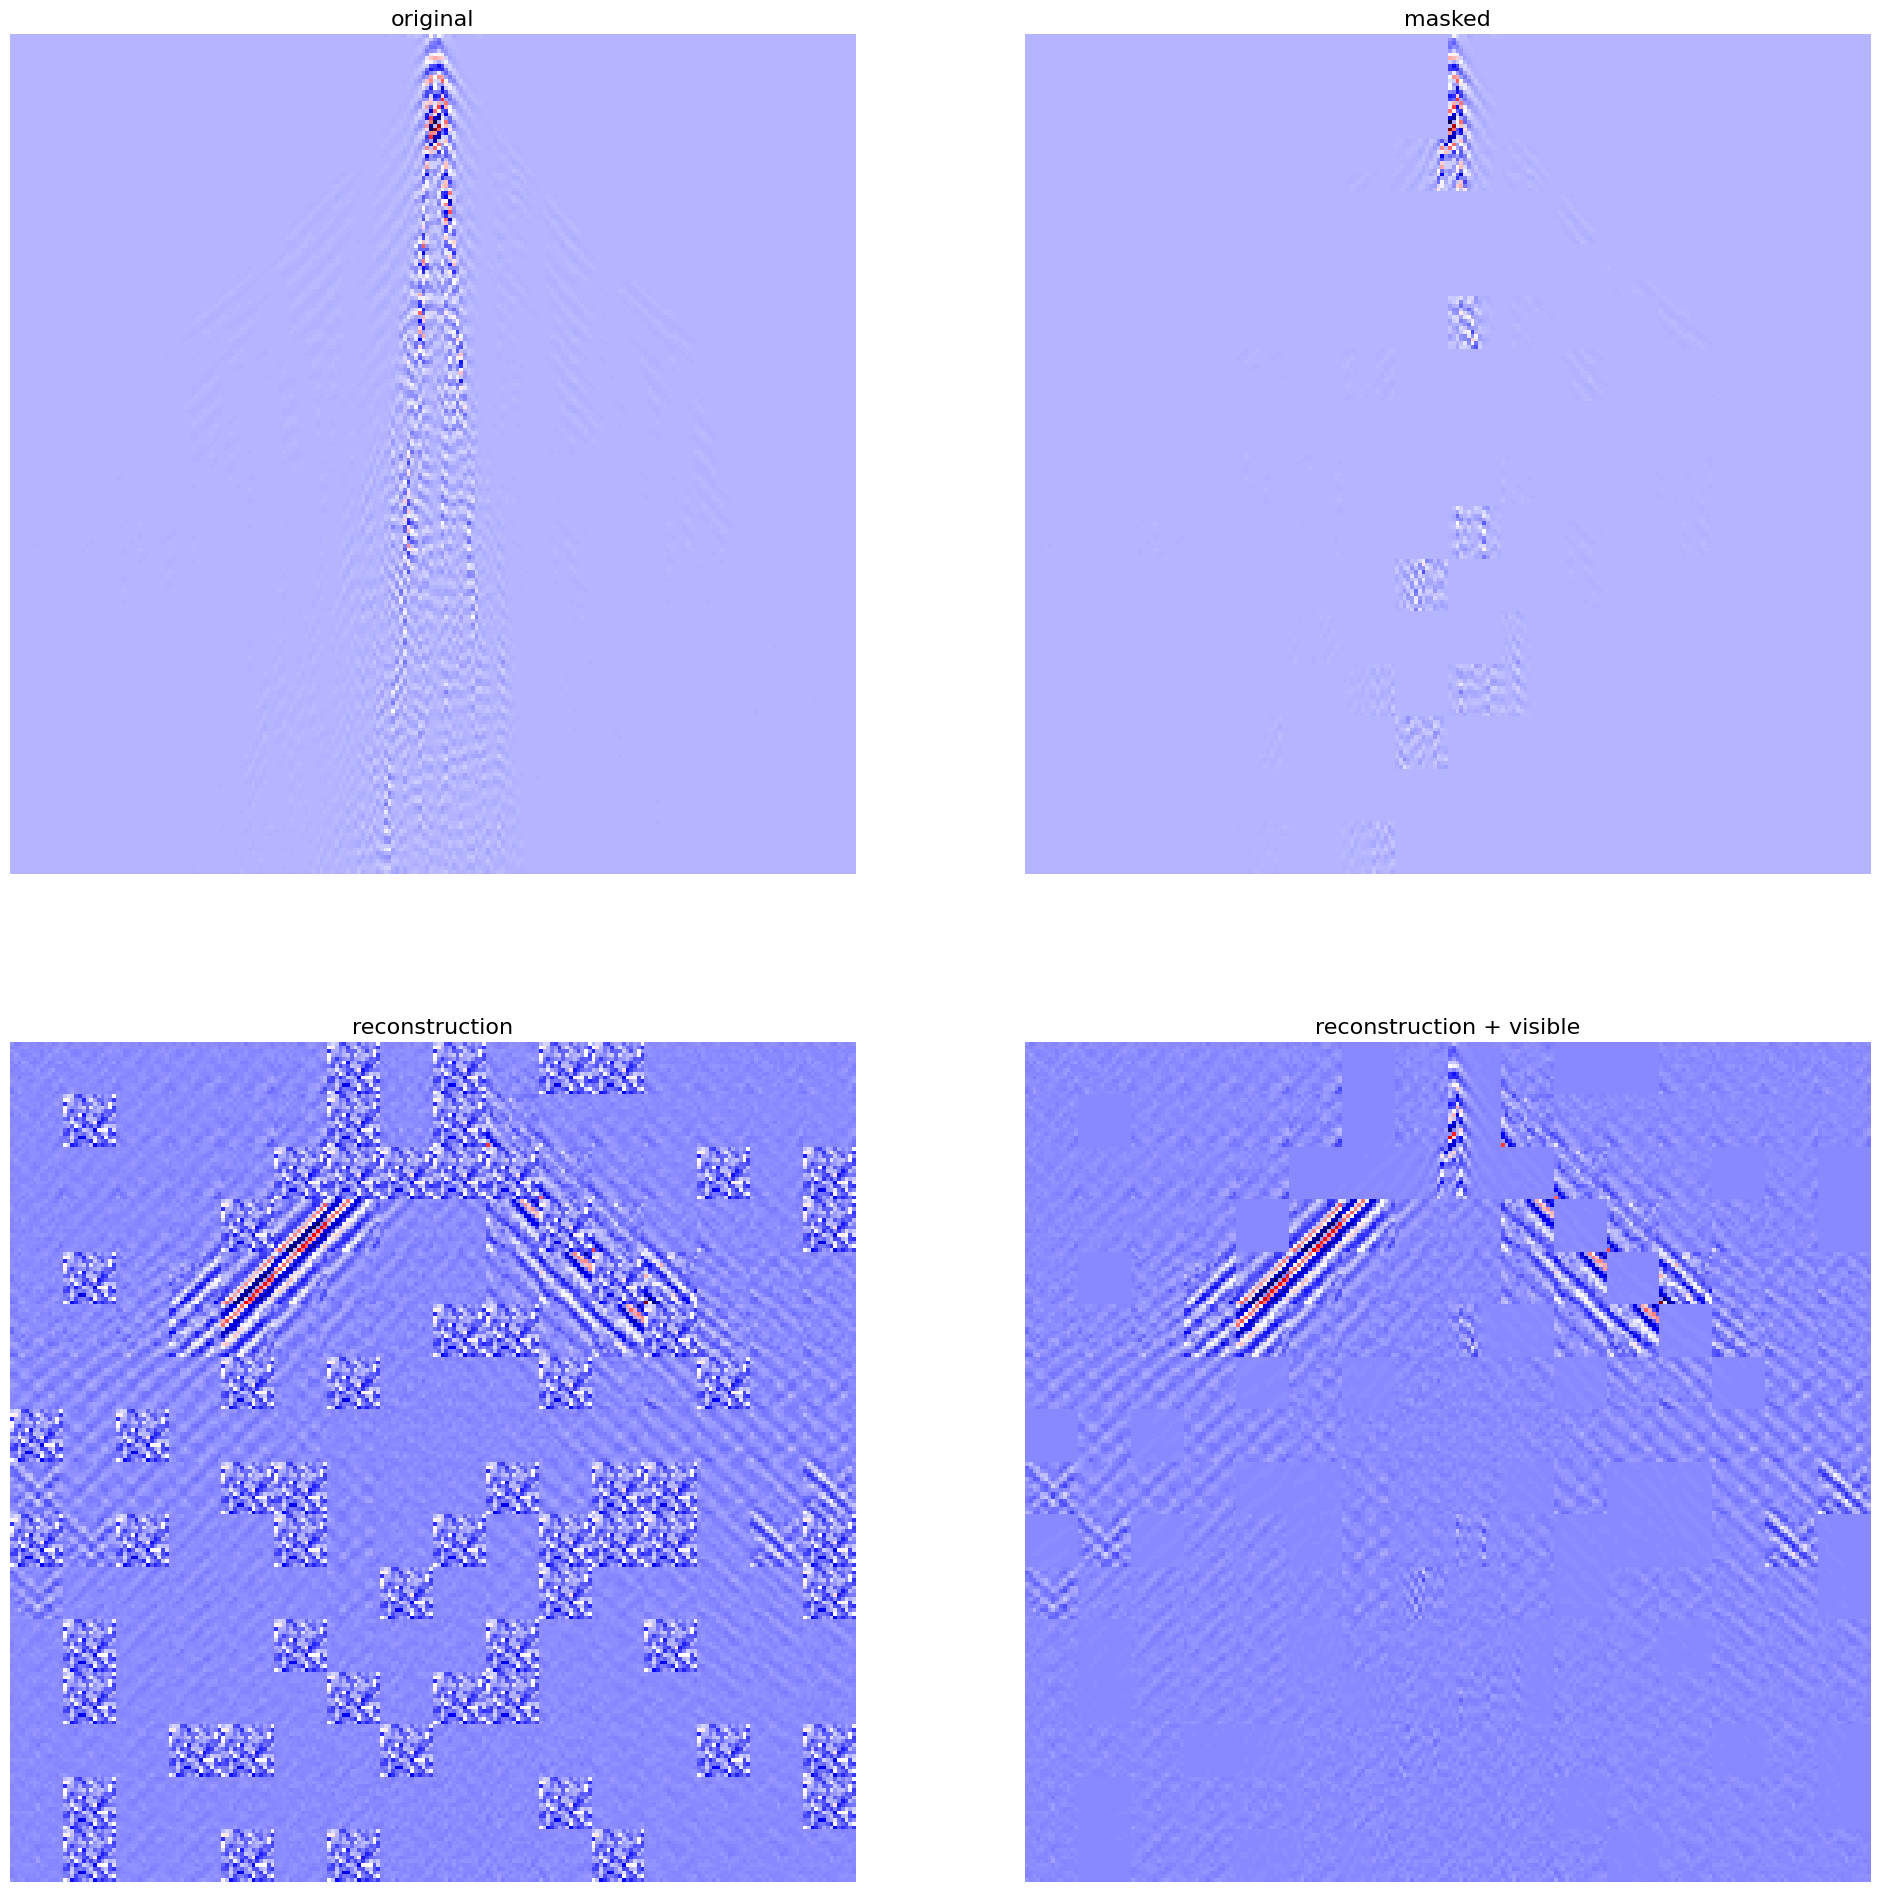

Validation batch shape: torch.Size([1, 3, 224, 224]) Indices: tensor([58])
MAE with pixel reconstruction:


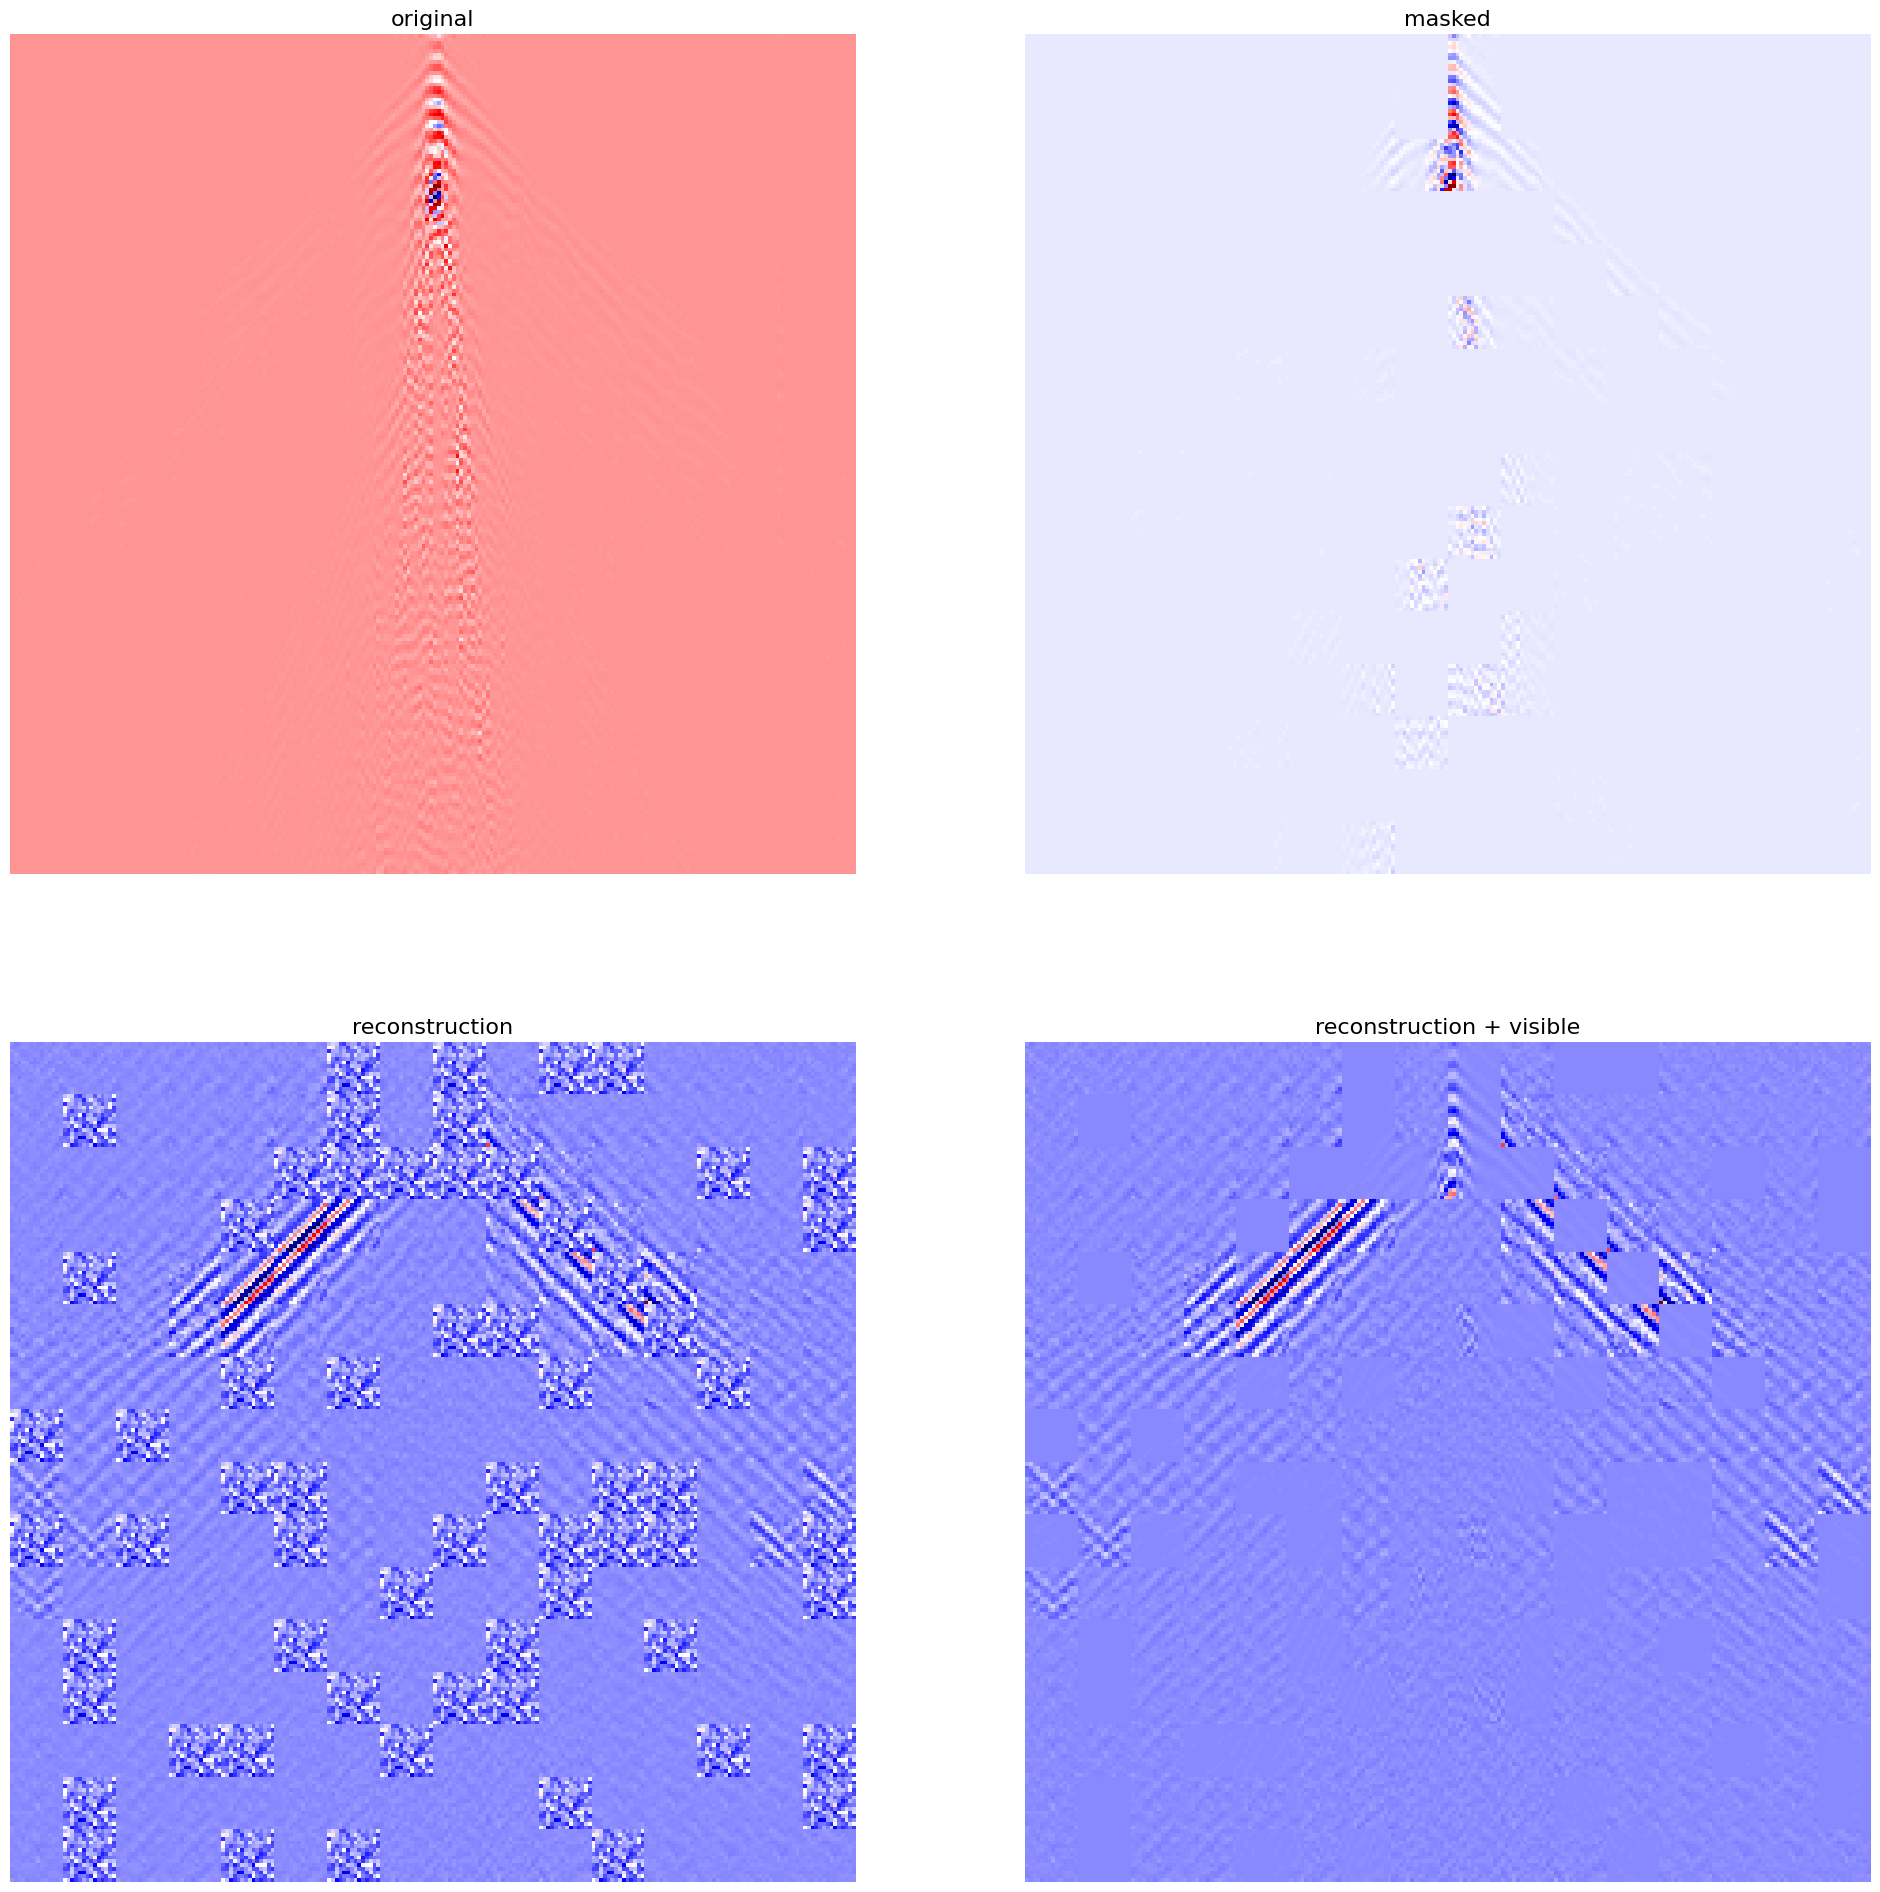

Validation batch shape: torch.Size([1, 3, 224, 224]) Indices: tensor([53])
MAE with pixel reconstruction:


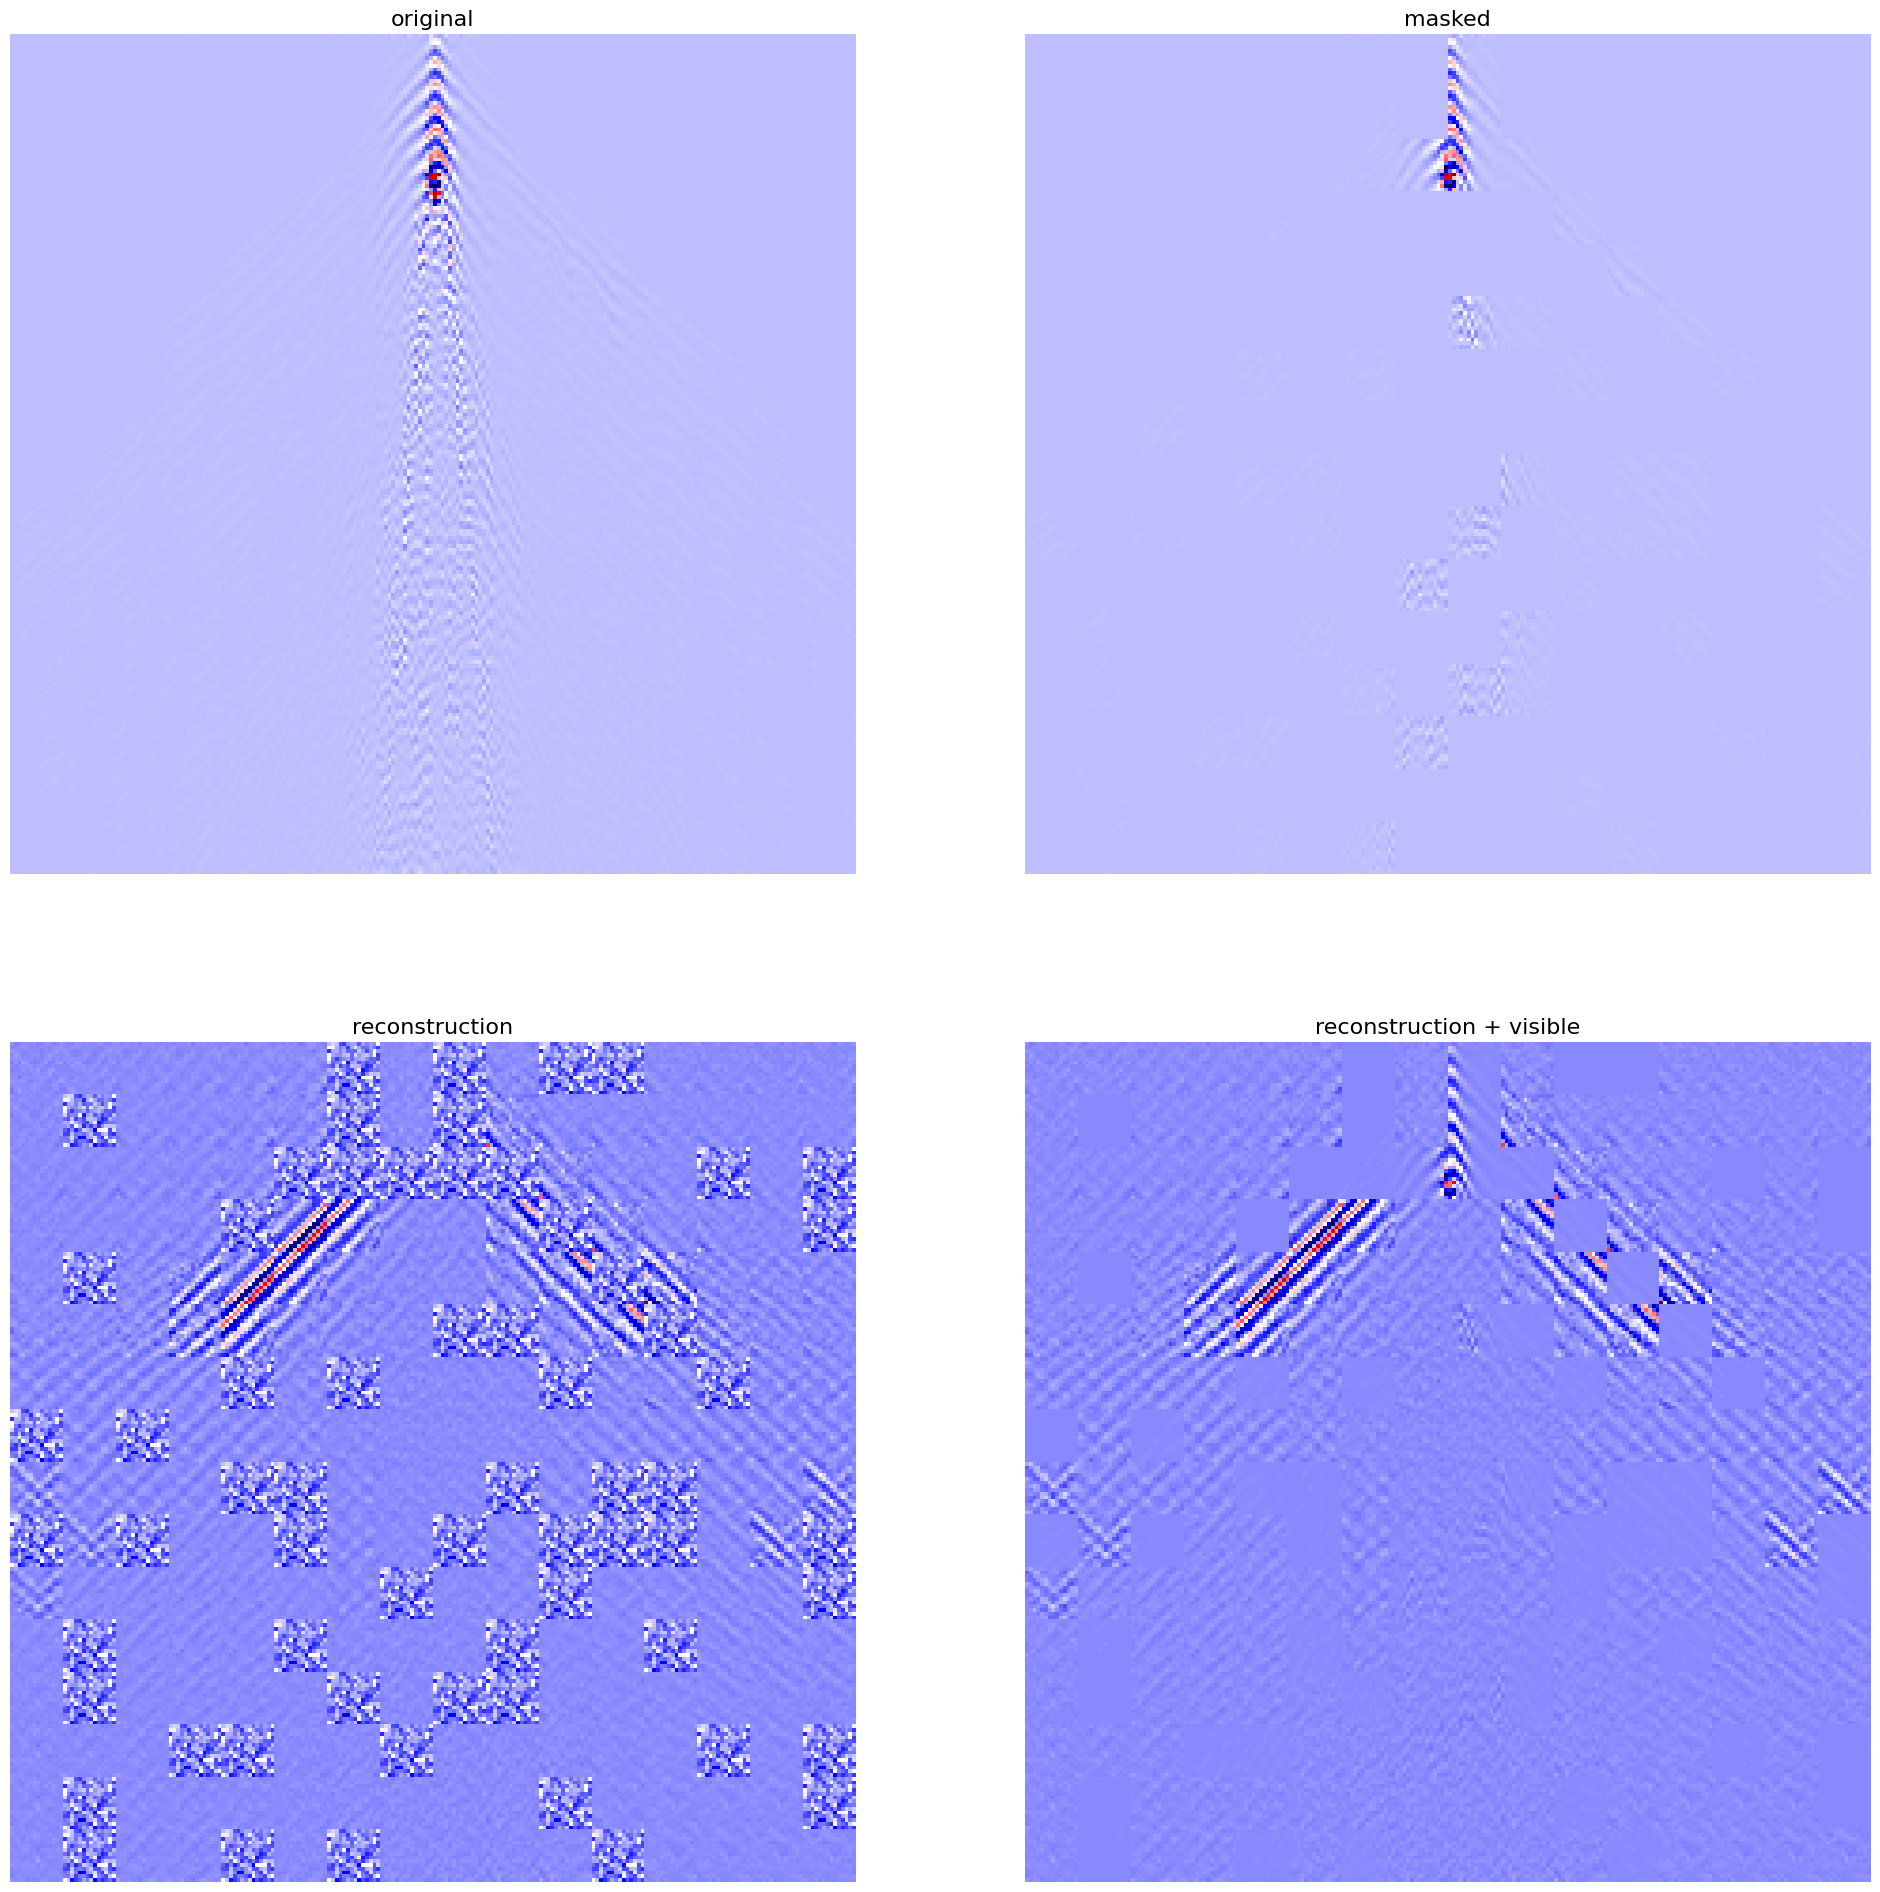

Validation batch shape: torch.Size([1, 3, 224, 224]) Indices: tensor([0])
MAE with pixel reconstruction:


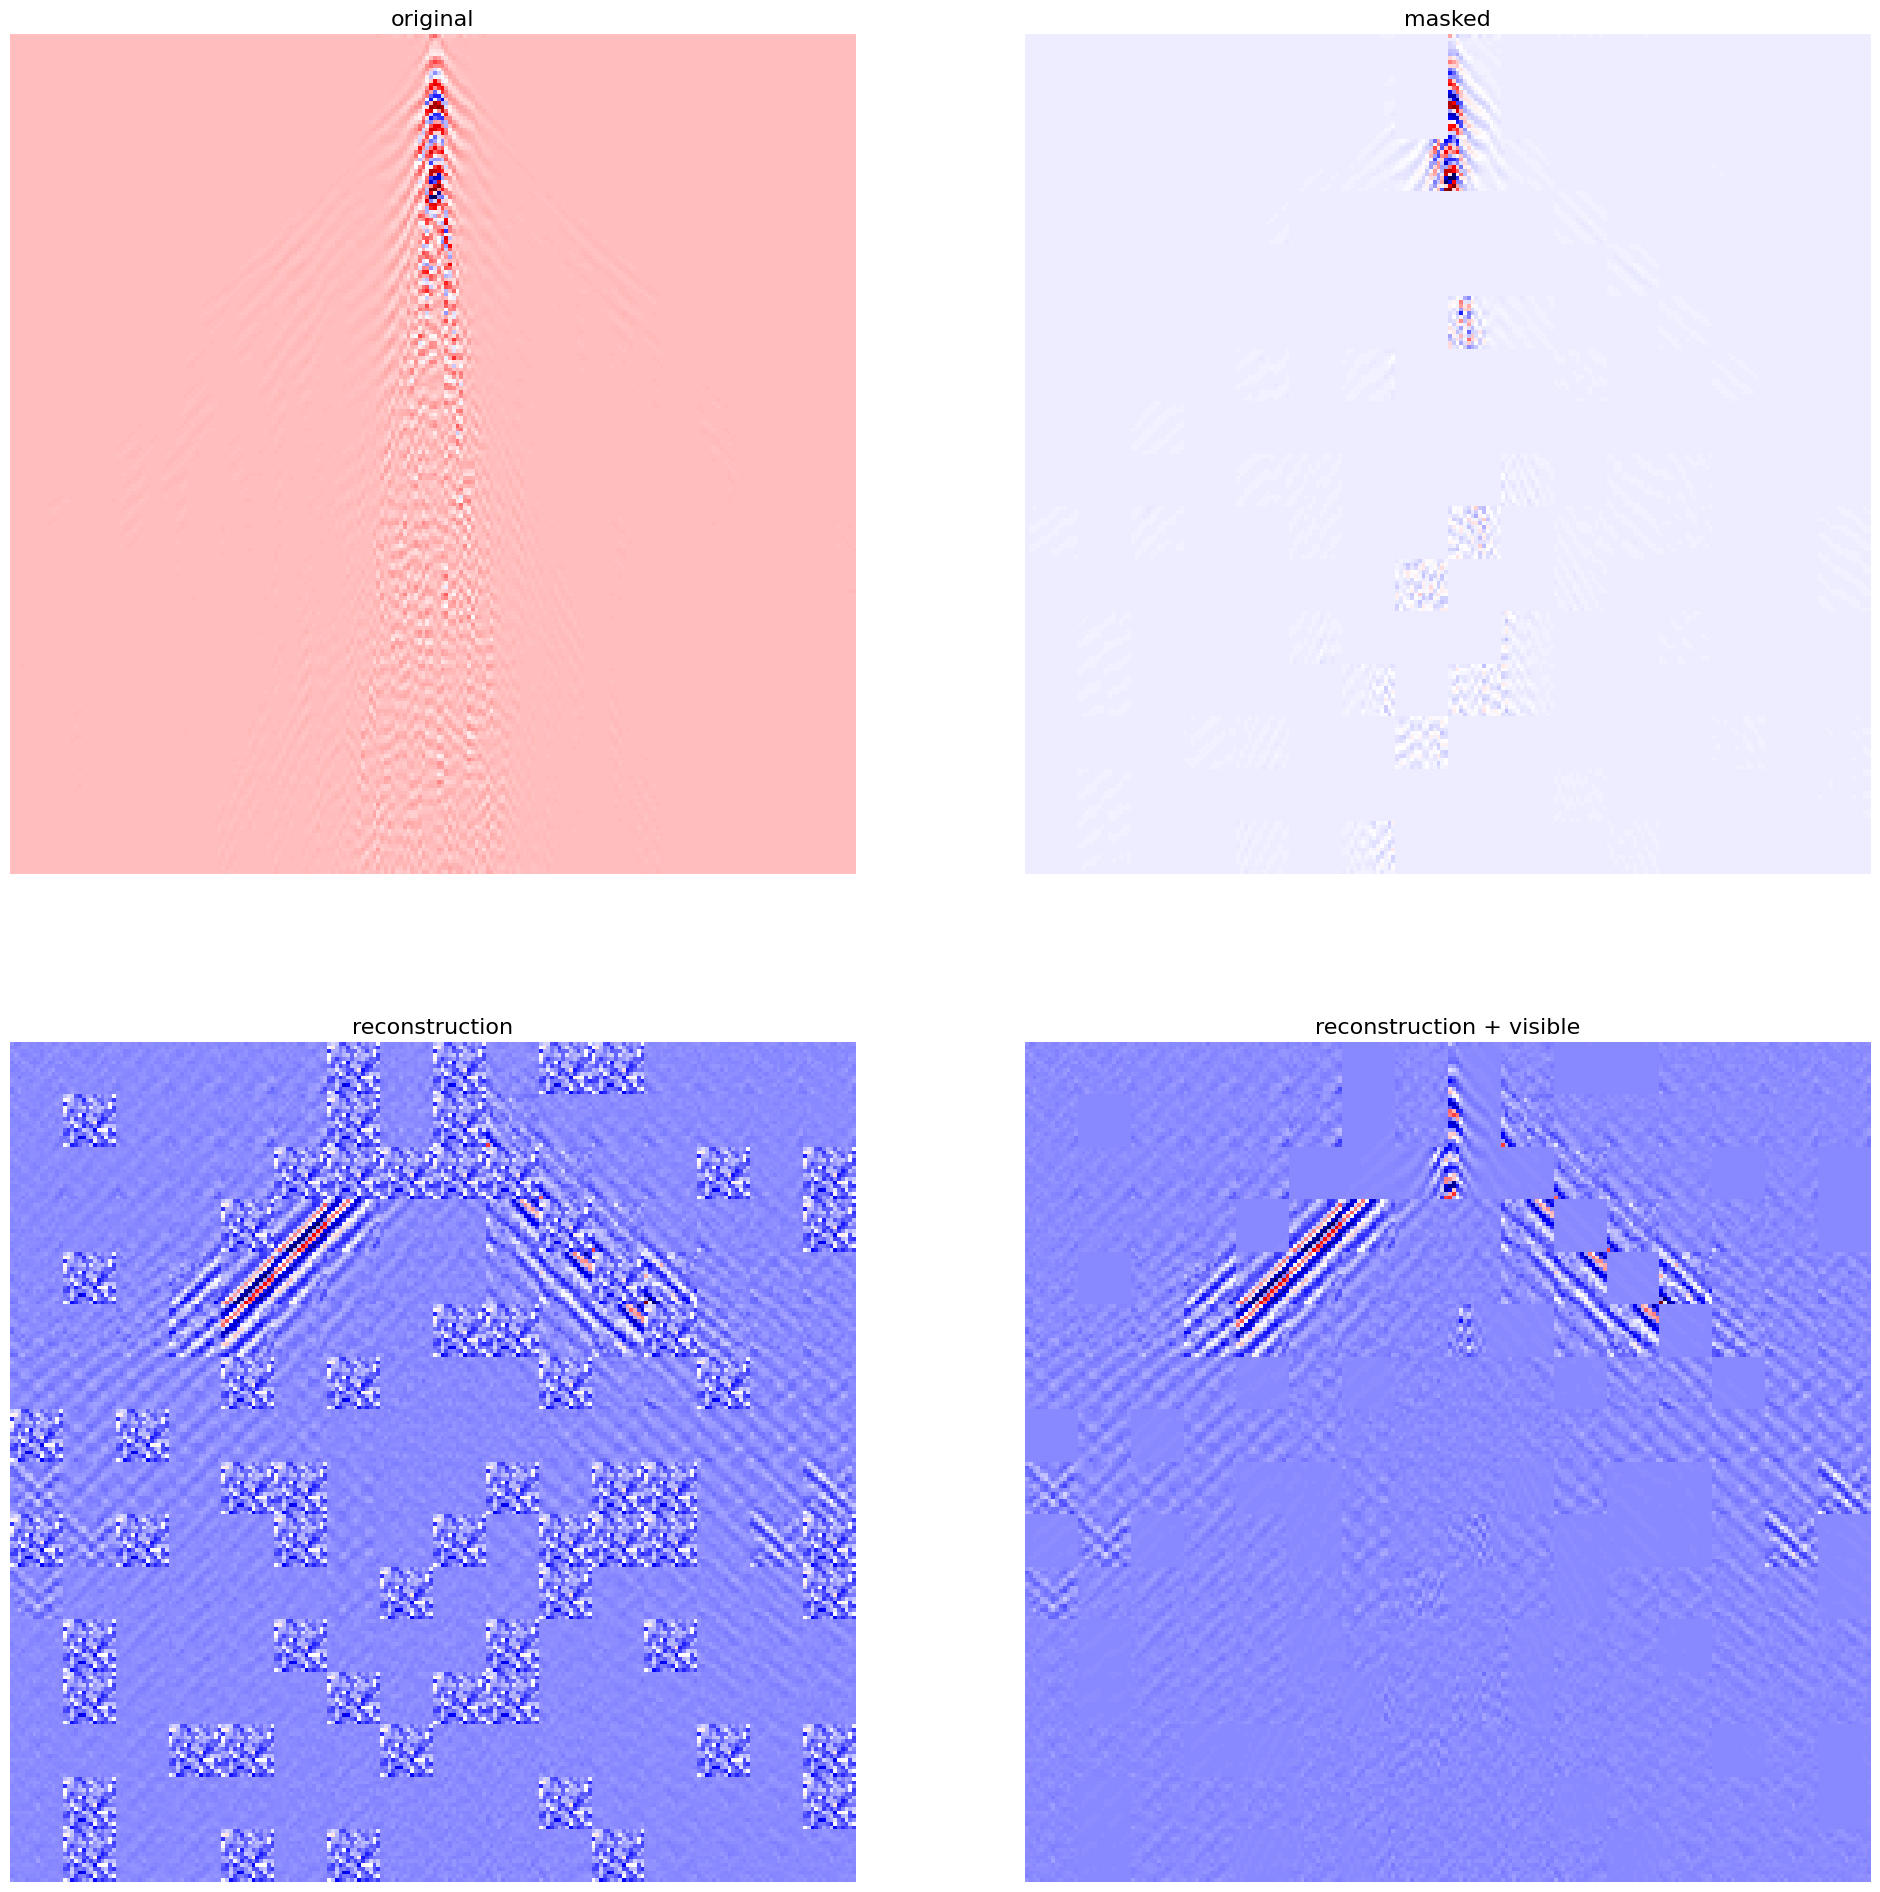

In [35]:
for batch_data, batch_indices in validation_loader:
    print("Validation batch shape:", batch_data.shape, "Indices:", batch_indices)
    # make random mask reproducible (comment out to make it change)
    torch.manual_seed(2)
    print('MAE with pixel reconstruction:')
    run_one_image(batch_data, model_mae)

In [ ]:
# Future Work ...